# Data Analysis: Self-Report

In this notebook, we wil be reading in the UV and then analysing the data according to the following hypotheses:

- H1:Long form viewing is associated with greater Enjoyment than Short form viewing (our rationale is that emotional engagement and narrative development are enhanced in Long form (i.e., in narrative context), which may increase Enjoyment).
- H2:Long form viewing is associated with better Recall than Short form viewing (rationale = contextual information aids memory encoding and retrieval).
- H3:Participants who are more Familiar with a Title may report higher Enjoyment than participants who are less familiar (rationale = prior exposure may increase emotional engagement and understanding of the content)
- H4:Participants who are more Familiar with a Title will show better Recall on average than those who are less familiar (rationale = familiarity may support memory retrieval through mental schema activation).
- E1:Is there a positive relationship between Enjoyment and Recall?

In addition to testing the hypothesis, we will also be generating visualisations as graphs. We must conduct appropriate statistical tests, and display the results of these tests on the graph itself as subtext.

Our design was a 2 x 2 between-subjects factorial:
- Factor 1 = Format (short form versus long form)
- Factor 2 = Familiarity with Title (we used a scale and decided on treating Familiarity as a moderator). The scores used for this will be the Screening questionnaire familiarity
- Random factor / variable = Titles / Genres (we're not focusing on specific Title / Genre interactions. Our focus is on the Format effect).

The 3 Target titles that we are mainly interested in are:
- Mad Max
- The Town
- Abbot Elementary

Other titles which appear in the data are there for control, comparison or as distractors. Therefore, hypotheses will primarily be answered using data from the target titles.

## TO-DO
3. Remove outliers
6. Generate 

### Exploratory

1. Develop a difference score (long_form enjoyment - short_form enjoyment / recall), a look for relationships with demographics
2. Basic desiptives of population: What is unique about people who saw the long format of Mad Max, split by groups
3. Correlations between enjoyment subscales

## Data Setup
We start by loading the unified view and preparing helpers for the column category inventory.

In [338]:
import csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import statsmodels.formula.api as smf
from scipy import stats

plt.rcParams['font.family'] = "Century Gothic"
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams.update({'font.size': 10})

# Example of formatting
# for spine in ["top", "right"]:
#         ax.spines[spine].set_visible(False)
#     ax.grid(axis="y", linestyle="--", alpha=0.3)
#     plt.tight_layout()
#     plt.show()

COLOR_MAP = {'Long': "#265f88",
             'Short': "#aa55c4",
             'Default': 'deepskyblue'}


In [339]:
from numbers import Number

def _fmt_stat(value, pattern="{:.3f}", placeholder="NA"):
    if value is None:
        return placeholder
    if isinstance(value, Number):
        if not np.isfinite(value):
            return placeholder
        return pattern.format(value)
    if pd.isna(value):
        return placeholder
    try:
        return pattern.format(value)
    except (ValueError, TypeError):
        return placeholder

In [340]:
def format_percent(value, decimals=0):
    """Return a percentage string for a 0-1 scaled value; fallback to NA when undefined."""
    if isinstance(value, Number):
        if not np.isfinite(value):
            return "NA"
        return f"{float(value) * 100:.{decimals}f}%"
    try:
        return f"{float(value) * 100:.{decimals}f}%"
    except (TypeError, ValueError):
        return "NA"


def percentage_point_phrase(long_value, short_value, decimals=0):
    """Describe the percentage-point lift or drop between long and short means."""
    if not (isinstance(long_value, Number) and isinstance(short_value, Number)):
        return "an indeterminate difference"
    if not (np.isfinite(long_value) and np.isfinite(short_value)):
        return "an indeterminate difference"
    diff = (float(long_value) - float(short_value)) * 100
    direction = "greater" if diff >= 0 else "lower"
    return f"{abs(diff):.{decimals}f}% {direction}"


def format_p_value(p_value):
    """Format p-values using the requested presentation style."""
    if not isinstance(p_value, Number) or not np.isfinite(p_value):
        return "p=NA"
    if p_value < 0.001:
        return "p<0.001"
    if p_value < 0.01:
        return f"p={p_value:.3f}"
    return f"p={p_value:.3f}"


def print_long_short_summary(label, long_mean, short_mean, p_value=None, extra_note=None, decimals=0):
    """Print the requested one-liner comparing long vs short form results."""
    long_txt = format_percent(long_mean, decimals)
    short_txt = format_percent(short_mean, decimals)
    diff_phrase = percentage_point_phrase(long_mean, short_mean, decimals)
    sig_txt = format_p_value(p_value) if p_value is not None else (extra_note or "")
    if sig_txt:
        sig_txt = f" ({sig_txt})"
    print(f"{label}: Long form ({long_txt}) showed {diff_phrase} than short form ({short_txt}){sig_txt}.")


def to_percent_table(frame, percent_columns, decimals=0):
    """Return a copy of frame with the specified columns rendered as percentage strings."""
    table = frame.copy()
    for column in percent_columns:
        if column in table.columns:
            table[column] = table[column].apply(lambda val: format_percent(val, decimals))
    return table

In [341]:
import re

PROJECT_ROOT = Path.cwd().parent
UV_PATH = PROJECT_ROOT / "results" / "uv_merged.csv"

uv = pd.read_csv(UV_PATH)
uv.columns = [re.sub(r"Abbot", "Abbott", col, flags=re.IGNORECASE) for col in uv.columns]
object_columns = uv.select_dtypes(include="object").columns
if len(object_columns) > 0:
    uv.loc[:, object_columns] = uv.loc[:, object_columns].apply(
        lambda series: series.str.replace(r"Abbot", "Abbott", regex=True, flags=re.IGNORECASE)
    )
uv.head()

,source_file,group,respondent,date_study,time_study,age,age_group,gender,ethnicity,income_group,...,distractor_Post_Recognition_Sum,fake_Post_Recognition_Count,fake_Post_Recognition_Mean,fake_Post_Recognition_NormalizedMean,fake_Post_Recognition_Sum,unseen_Post_Recognition_Count,unseen_Post_Recognition_Mean,unseen_Post_Recognition_NormalizedMean,unseen_Post_Recognition_Sum,post_survey_source_path
0,003_104.csv,A,104,10/16/2025,18:09:03,59,44-59,Male,White,"$60,000 or more per year",...,1.0,4.0,0.6875,0.6875,2.75,1.0,0.00,0.00,0.00,data/Post/Group A_ Post Viewing Questionnaire ...
1,002_106.csv,A,106,10/16/2025,19:35:05,30,28-43,Male,White,"$60,000 or more per year",...,2.0,4.0,1.0000,1.0000,4.00,1.0,0.75,0.75,0.75,data/Post/Group A_ Post Viewing Questionnaire ...
2,001_116.csv,A,116,10/18/2025,12:37:40,19,18-27,Male,White,"$35,000  $60,000 per year",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,006_14.csv,A,14,10/11/2025,09:32:42,33,28-43,Male,Hispanic/Latino/Latina/Latinx,"$60,000 or more per year",...,1.0,4.0,0.8125,0.8125,3.25,1.0,1.00,1.00,1.00,data/Post/Group A_ Post Viewing Questionnaire ...
4,007_3.csv,A,3,10/10/2025,09:19:22,34,28-43,Female,White,"$60,000 or more per year",...,2.0,4.0,1.0000,1.0000,4.00,1.0,1.00,1.00,1.00,data/Post/Group A_ Post Viewing Questionnaire ...


In [342]:
demographic_exact = {
    "respondent_id",
    "group",
    "age",
    "age_group",
    "gender",
    "ethnicity",
    "income_group",
    "content_consumption",
    "grid_comments",
    "date_study",
    "time_study",
    "post_survey_source_path"
}

demographic_keywords = ("demographic", "respondent", "grid", "age", "gender", "ethnic", "income", "content_consumption", "comments", "group")
enjoyment_keywords = ("enjoy",)
familiarity_keywords = ("familiar",)
recognition_keywords = ("recognition", "recall")

def assign_category(column_name: str) -> str:
    name_lower = column_name.lower()
    if column_name in demographic_exact or any(keyword in name_lower for keyword in demographic_keywords):
        return "demographics"
    if any(keyword in name_lower for keyword in enjoyment_keywords):
        return "enjoyment"
    if any(keyword in name_lower for keyword in familiarity_keywords):
        return "familiarity"
    if any(keyword in name_lower for keyword in recognition_keywords):
        return "recognition"
    return "other"

column_categories = [assign_category(column) for column in uv.columns]

column_category_df = pd.DataFrame({
    "header": uv.columns,
    "category": column_categories,
})

category_csv_path = PROJECT_ROOT / "results" / "uv_column_categories.csv"
column_category_df.to_csv(category_csv_path, index=False)

column_category_df["category"].value_counts().to_frame()

,count
category,
other,161
recognition,149
enjoyment,145
familiarity,50
demographics,18


In [343]:
print(uv.group.value_counts().to_frame())
print(uv['Long Form'].value_counts().to_frame())

       count
group       
D         17
C         16
E         14
F         14
A         12
B         10
                   count
Long Form               
Abbott Elementary     30
The Town              29
Mad Max               24


## Hypothesis 1 – Format and Enjoyment
We evaluate whether long-form content drives greater enjoyment than short-form content using the unified view (`uv_merged.csv`). The workflow below:
- isolates the enjoyment composites and reshapes them into a tidy form;
- runs within-subject tests on respondents who experienced both formats (Part 1);
- fits title-level mixed-effects models that treat title as a random intercept (Part 2);
- expands the analysis to normalized enjoyment subscales; and
- inventories the question counts contributing to each subscale so we can interpret scaling differences.

Part 1 emphasises the normalized composites that put short and long forms on the same 0–1 scale. Part 2 retains the broader composite set to check whether title-level effects replicate across alternative scalings.

In [344]:
[col for col in uv.columns if "Enjoyment" in col][:20]

['Long_The Town_Survey_Enjoyment_E1',
 'Long_The Town_Survey_Enjoyment_E12',
 'Long_The Town_Survey_Enjoyment_E14',
 'Long_The Town_Survey_Enjoyment_E15',
 'Long_The Town_Survey_Enjoyment_E17',
 'Long_The Town_Survey_Enjoyment_E18',
 'Long_The Town_Survey_Enjoyment_E19',
 'Long_The Town_Survey_Enjoyment_E2',
 'Long_The Town_Survey_Enjoyment_E20',
 'Long_The Town_Survey_Enjoyment_E3',
 'Long_The Town_Survey_Enjoyment_E4',
 'Long_The Town_Survey_Enjoyment_E9',
 'Short_Mad Max_Survey_Enjoyment_E1',
 'Short_Mad Max_Survey_Enjoyment_E12',
 'Short_Mad Max_Survey_Enjoyment_E14',
 'Short_Mad Max_Survey_Enjoyment_E15',
 'Short_Mad Max_Survey_Enjoyment_E17',
 'Short_Mad Max_Survey_Enjoyment_E18',
 'Short_Mad Max_Survey_Enjoyment_E19',
 'Short_Mad Max_Survey_Enjoyment_E2']

In [345]:
[col for col in uv.columns if "EnjoymentComposite" in col]

['Long_The Town_Survey_EnjoymentComposite_Count',
 'Long_The Town_Survey_EnjoymentComposite_Sum',
 'Long_The Town_Survey_EnjoymentComposite_Corrected',
 'Long_The Town_Survey_EnjoymentComposite_Mean',
 'Long_The Town_Survey_EnjoymentComposite_Normalized',
 'Long_The Town_Survey_EnjoymentComposite_NormalizedCorrected',
 'Short_Mad Max_Survey_EnjoymentComposite_Count',
 'Short_Mad Max_Survey_EnjoymentComposite_Sum',
 'Short_Mad Max_Survey_EnjoymentComposite_Corrected',
 'Short_Mad Max_Survey_EnjoymentComposite_Mean',
 'Short_Mad Max_Survey_EnjoymentComposite_Normalized',
 'Short_Mad Max_Survey_EnjoymentComposite_NormalizedCorrected',
 'Long_Mad Max_Survey_EnjoymentComposite_Count',
 'Long_Mad Max_Survey_EnjoymentComposite_Sum',
 'Long_Mad Max_Survey_EnjoymentComposite_Corrected',
 'Long_Mad Max_Survey_EnjoymentComposite_Mean',
 'Long_Mad Max_Survey_EnjoymentComposite_Normalized',
 'Long_Mad Max_Survey_EnjoymentComposite_NormalizedCorrected',
 'Short_The Town_Survey_EnjoymentComposite_Cou

In [346]:
import re

ENJOYMENT_METRICS_ALL = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
    "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean",
]
METRIC_LABELS = {
    "EnjoymentComposite_Normalized": "EnjoymentComposite_Normalised",
    "EnjoymentComposite_NormalizedCorrected": "EnjoymentComposite_NormalisedCorrected",
    "EnjoymentComposite_Sum": "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected": "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean": "EnjoymentComposite_Mean",
}
METRIC_YLABELS = {
    "EnjoymentComposite_Normalized": "Normalized Enjoyment Score",
    "EnjoymentComposite_NormalizedCorrected": "Normalized Enjoyment Score",
    "EnjoymentComposite_Sum": "Composite Enjoyment Sum",
    "EnjoymentComposite_Corrected": "Polarity-Corrected Sum",
    "EnjoymentComposite_Mean": "Average Enjoyment Score",
}
PART1_METRICS = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
]
PART2_METRICS = [
    "EnjoymentComposite_Normalized",
    "EnjoymentComposite_NormalizedCorrected",
    "EnjoymentComposite_Sum",
    "EnjoymentComposite_Corrected",
    "EnjoymentComposite_Mean",
]
TARGET_TITLES = ["Mad Max", "The Town", "Abbott Elementary"]

id_column = "respondent_id" if "respondent_id" in uv.columns else uv.columns[0]

long_frames = []
for metric in ENJOYMENT_METRICS_ALL:
    metric_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(metric)}$")
    metric_columns = [col for col in uv.columns if metric_pattern.match(col)]
    for column in metric_columns:
        form, title_token = metric_pattern.match(column).groups()
        title_clean = title_token.replace("_", " ").strip()
        frame = (
            uv[[id_column, column]]
            .rename(columns={column: "value"})
            .assign(form=form, title=title_clean, metric=metric)
)
        long_frames.append(frame)

if not long_frames:
    raise ValueError("No enjoyment columns matching the expected pattern were found in uv_merged.csv")

enjoyment_long = (
    pd.concat(long_frames, ignore_index=True)
    .dropna(subset=["value"])
)
enjoyment_long[id_column] = enjoyment_long[id_column].astype(str)
enjoyment_long["form"] = pd.Categorical(enjoyment_long["form"], categories=["Short", "Long"], ordered=True)

title_overview = enjoyment_long.groupby(["metric", "title", "form"], observed=True).size().rename("records").reset_index()
title_overview

,metric,title,form,records
0,EnjoymentComposite_Corrected,Abbott Elementary,Short,30
1,EnjoymentComposite_Corrected,Abbott Elementary,Long,30
2,EnjoymentComposite_Corrected,Mad Max,Short,26
3,EnjoymentComposite_Corrected,Mad Max,Long,23
4,EnjoymentComposite_Corrected,The Town,Short,26
5,EnjoymentComposite_Corrected,The Town,Long,28
6,EnjoymentComposite_Mean,Abbott Elementary,Short,30
7,EnjoymentComposite_Mean,Abbott Elementary,Long,30
8,EnjoymentComposite_Mean,Mad Max,Short,26
9,EnjoymentComposite_Mean,Mad Max,Long,23


### Part 1: Normalized Within-Subject Comparison
For each enjoyment composite we average the Long and Short responses per respondent and run a paired, one-tailed t-test on the Long–Short difference (expecting Long > Short). Plots are restricted to the normalized variants so visual conclusions align to the per-item scaling.

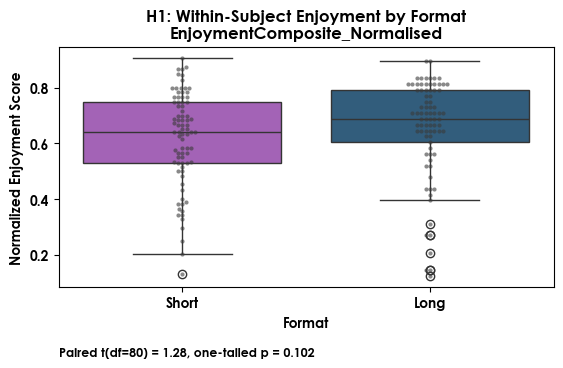

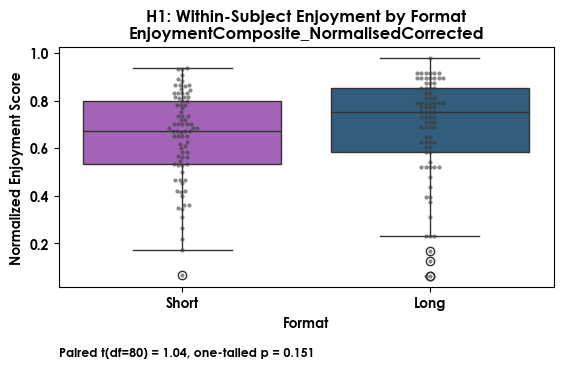

,metric,n_paired,t_stat,df,p_one_tailed
0,EnjoymentComposite_Normalised,81,1.281099,80,0.101930
1,EnjoymentComposite_NormalisedCorrected,81,1.039125,80,0.150939


In [347]:
def one_tailed_p_from_paired_t(long_values, short_values):
    paired = pd.DataFrame({"Long": long_values, "Short": short_values}).dropna()
    if paired.empty:
        raise ValueError("No respondents have both Long and Short enjoyment scores available.")
    t_stat, p_two = stats.ttest_rel(paired["Long"], paired["Short"], nan_policy="omit")
    df = paired.shape[0] - 1
    p_one = stats.t.sf(t_stat, df)
    return t_stat, df, p_one, paired

within_subject_summaries = []

for metric in PART1_METRICS:
    metric_label = METRIC_LABELS[metric]
    metric_df = enjoyment_long.loc[enjoyment_long["metric"] == metric]
    respondent_means = metric_df.groupby([id_column, "form"], observed=True)['value'].mean().unstack()
    try:
        t_stat, df_val, p_one, paired = one_tailed_p_from_paired_t(respondent_means["Long"], respondent_means["Short"])
    except ValueError as exc:
        print(f"{metric_label}: {exc}")
        continue
    within_subject_summaries.append({
        "metric": metric_label,
        "n_paired": paired.shape[0],
        "t_stat": t_stat,
        "df": df_val,
        "p_one_tailed": p_one,
    })
    plot_data = paired.reset_index().melt(id_vars=id_column, value_vars=["Short", "Long"], var_name="form", value_name="value")
    palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.28, right=0.95)
    sns.boxplot(data=plot_data, x="form", y="value", order=["Short", "Long"], hue="form", palette=palette, dodge=False, legend=False, ax=ax)
    sns.swarmplot(data=plot_data, x="form", y="value", order=["Short", "Long"], color="#3a3a3a", size=3, alpha=0.6, ax=ax)
    ax.set_title(f"H1: Within-Subject Enjoyment by Format\n{metric_label}")
    ax.set_xlabel("Format")
    ax.set_ylabel(METRIC_YLABELS.get(metric, "Enjoyment Score"))
    annotation = f"Paired t(df={df_val}) = {t_stat:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.25, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()

pd.DataFrame(within_subject_summaries)

In [348]:
h1_part1_summary_rows = []
for metric in PART1_METRICS:
    metric_label = METRIC_LABELS[metric]
    metric_df = enjoyment_long.loc[enjoyment_long["metric"] == metric]
    respondent_means = (
        metric_df.groupby([id_column, "form"], observed=True)["value"].mean().unstack()
    )
    if respondent_means.empty or not {"Short", "Long"}.issubset(respondent_means.columns):
        continue
    long_scores = respondent_means["Long"]
    short_scores = respondent_means["Short"]
    long_mean = long_scores.mean()
    short_mean = short_scores.mean()
    diff = long_mean - short_mean
    try:
        t_stat, df_val, p_one, _paired = one_tailed_p_from_paired_t(long_scores, short_scores)
        n_paired = _paired.shape[0]
    except ValueError:
        p_one = np.nan
        n_paired = int(min(long_scores.notna().sum(), short_scores.notna().sum()))
    h1_part1_summary_rows.append({
        "Metric": metric_label,
        "Long mean": long_mean,
        "Short mean": short_mean,
        "Difference": diff,
        "p (one-tailed)": p_one,
        "n paired": n_paired,
    })
if h1_part1_summary_rows:
    h1_part1_summary = pd.DataFrame(h1_part1_summary_rows)
    display(to_percent_table(h1_part1_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
    preferred_label = METRIC_LABELS.get("EnjoymentComposite_NormalizedCorrected")
    preferred_row = next(
        (row for row in h1_part1_summary_rows if row["Metric"] == preferred_label),
        h1_part1_summary_rows[0],
    )
    extra_items = []
    preferred_p = preferred_row.get("p (one-tailed)")
    if isinstance(preferred_p, Number) and np.isfinite(preferred_p):
        extra_items.append(format_p_value(preferred_p))
    n_paired_val = preferred_row.get("n paired")
    if isinstance(n_paired_val, Number) and np.isfinite(n_paired_val):
        extra_items.append(f"n_pairs={int(n_paired_val)}")
    extra_note = ", ".join(extra_items) if extra_items else None
    print_long_short_summary(
        label=f"H1 Part 1 ({preferred_row['Metric']})",
        long_mean=preferred_row["Long mean"],
        short_mean=preferred_row["Short mean"],
        extra_note=extra_note
    )
else:
    print("H1 Part 1 summary: Insufficient paired data to summarise.")

,Metric,Long mean,Short mean,Difference,p (one-tailed),n paired
0,EnjoymentComposite_Normalised,65.5%,61.5%,4.0%,0.101930,81
1,EnjoymentComposite_NormalisedCorrected,68.1%,64.2%,3.9%,0.150939,81


H1 Part 1 (EnjoymentComposite_NormalisedCorrected): Long form (68%) showed 4% greater than short form (64%) (p=0.151, n_pairs=81).


### Part 2: Mixed Models by Title
We restrict to the three target titles, convert format into a binary predictor, and fit mixed-effects models with title as a random intercept. The coefficient on `form_long` estimates the expected Long–Short lift while accounting for title-to-title variability. Visuals highlight each title’s distribution alongside the model summary.

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

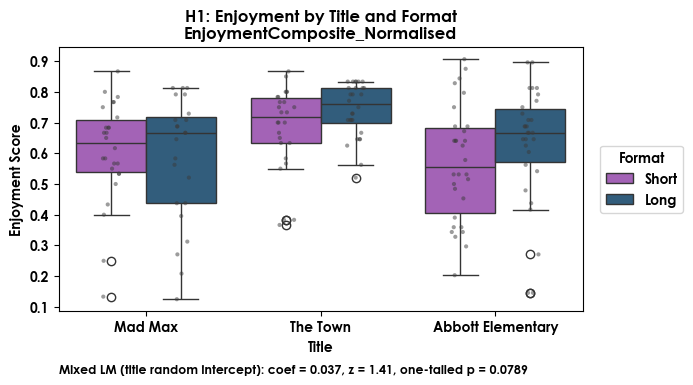

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

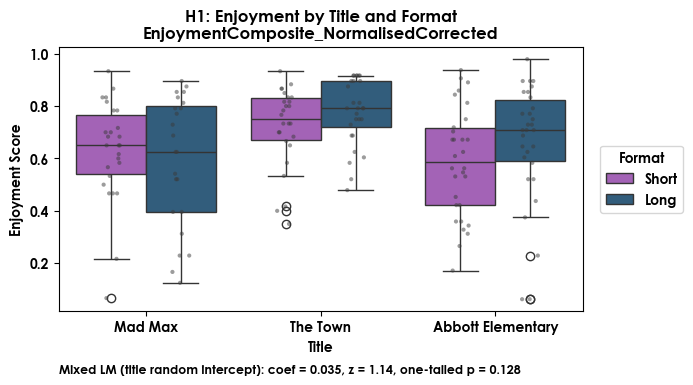

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

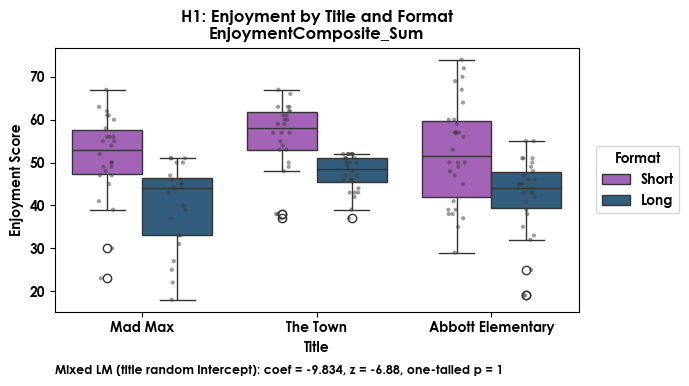

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

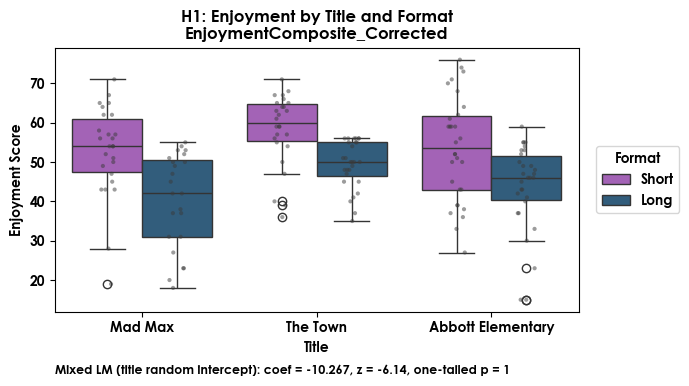

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

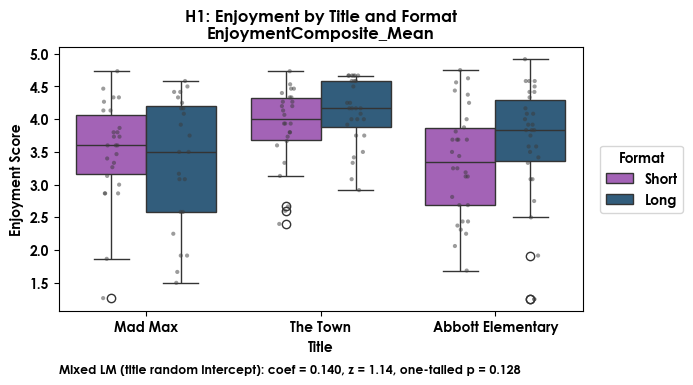

,metric,coef_form_long,z_value,p_one_tailed,n_observations,titles_included
0,EnjoymentComposite_Normalised,0.036647,1.412361,0.078922,163,3
1,EnjoymentComposite_NormalisedCorrected,0.034928,1.135218,0.128142,163,3
2,EnjoymentComposite_Sum,-9.834368,-6.879121,1.000000,163,3
3,EnjoymentComposite_Corrected,-10.267069,-6.136619,1.000000,163,3
4,EnjoymentComposite_Mean,0.139712,1.135218,0.128142,163,3


In [349]:
between_subject_summaries = []
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}

for metric in PART2_METRICS:
    metric_label = METRIC_LABELS[metric]
    subset = enjoyment_long.loc[
        (enjoyment_long["metric"] == metric)
        & enjoyment_long["title"].isin(TARGET_TITLES)
    ].copy()
    if subset.empty:
        print(f"No data available for {metric_label} when filtering to target titles.")
        continue
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
    except Exception as exc:
        print(f"Mixed model failed for {metric_label}: {exc}")
        continue
    coef = mixed_result.params.get("form_long", np.nan)
    se = mixed_result.bse.get("form_long", np.nan)
    z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
    p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    between_subject_summaries.append({
        "metric": metric_label,
        "coef_form_long": coef,
        "z_value": z_val,
        "p_one_tailed": p_one,
        "n_observations": subset.shape[0],
        "titles_included": subset["title"].nunique(),
    })
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.22, right=0.78)
    sns.boxplot(data=subset, x="title", y="value", hue="form", palette=palette, order=TARGET_TITLES, hue_order=["Short", "Long"], ax=ax)
    sns.stripplot(data=subset, x="title", y="value", hue="form", palette={"Short": "#3a3a3a", "Long": "#3a3a3a"}, order=TARGET_TITLES, hue_order=["Short", "Long"], dodge=True, size=3, alpha=0.5, ax=ax, legend=False)
    ax.set_title(f"H1: Enjoyment by Title and Format\n{metric_label}")
    ax.set_xlabel("Title")
    ax.set_ylabel("Enjoyment Score")
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.2, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()

pd.DataFrame(between_subject_summaries)

In [350]:
metric_key = "EnjoymentComposite_NormalizedCorrected"
metric_label = METRIC_LABELS[metric_key]
subset = enjoyment_long.loc[
    (enjoyment_long["metric"] == metric_key)
    & enjoyment_long["title"].isin(TARGET_TITLES)
].copy()
if subset.empty:
    print("H1 Part 2 summary: No data available for target titles.")
else:
    p_lookup = next(
        (row for row in between_subject_summaries if row["metric"] == metric_label),
        {},
    )
    overall_p_value = p_lookup.get("p_one_tailed")
    title_rows = []
    for title in TARGET_TITLES:
        title_df = subset.loc[subset["title"] == title]
        if title_df.empty:
            continue
        long_vals = title_df.loc[title_df["form"] == "Long", "value"].dropna()
        short_vals = title_df.loc[title_df["form"] == "Short", "value"].dropna()
        if long_vals.empty or short_vals.empty:
            continue
        long_mean = long_vals.mean()
        short_mean = short_vals.mean()
        diff = long_mean - short_mean
        t_stat, p_two = stats.ttest_ind(long_vals, short_vals, equal_var=False, nan_policy="omit")
        if np.isnan(t_stat) or np.isnan(p_two):
            p_one = np.nan
        else:
            if t_stat >= 0:
                p_one = p_two / 2
            else:
                p_one = 1 - (p_two / 2)
        title_rows.append({
            "Title": title,
            "Long mean": long_mean,
            "Short mean": short_mean,
            "Difference": diff,
            "p (one-tailed, title)": p_one,
            "n Long": int(long_vals.count()),
            "n Short": int(short_vals.count()),
        })
    if not title_rows:
        print("H1 Part 2 summary: No target-title records after filtering.")
    else:
        h1_part2_title_summary = pd.DataFrame(title_rows)
        display(to_percent_table(h1_part2_title_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
        for row in title_rows:
            overall_tag = None
            if overall_p_value is not None:
                if isinstance(overall_p_value, Number) and np.isfinite(overall_p_value):
                    overall_tag = f"overall mixed-model {format_p_value(overall_p_value)}"
            sample_note = f"n_long={row['n Long']}, n_short={row['n Short']}"
            extra = ", ".join(filter(None, [format_p_value(row.get("p (one-tailed, title)")), sample_note, overall_tag]))
            print_long_short_summary(
                label=f"H1 Part 2 – {row['Title']} ({metric_label})",
                long_mean=row["Long mean"],
                short_mean=row["Short mean"],
                extra_note=extra
            )
        overall_long = subset.loc[subset["form"] == "Long", "value"].mean()
        overall_short = subset.loc[subset["form"] == "Short", "value"].mean()
        overall_counts = {
            "n_long": int(subset.loc[subset["form"] == "Long", "value"].notna().sum()),
            "n_short": int(subset.loc[subset["form"] == "Short", "value"].notna().sum()),
        }
        sample_note = f"n_long={overall_counts['n_long']}, n_short={overall_counts['n_short']}"
        extra = ", ".join(filter(None, [format_p_value(overall_p_value), sample_note]))
        print_long_short_summary(
            label=f"H1 Part 2 (Overall {metric_label})",
            long_mean=overall_long,
            short_mean=overall_short,
            extra_note=extra
        )

,Title,Long mean,Short mean,Difference,"p (one-tailed, title)",n Long,n Short
0,Mad Max,59.1%,62.9%,-3.9%,0.724504,23,26
1,The Town,77.8%,72.1%,5.8%,0.070358,28,26
2,Abbott Elementary,65.8%,58.4%,7.4%,0.098227,30,30


H1 Part 2 – Mad Max (EnjoymentComposite_NormalisedCorrected): Long form (59%) showed 4% lower than short form (63%) (p=0.725, n_long=23, n_short=26, overall mixed-model p=0.128).
H1 Part 2 – The Town (EnjoymentComposite_NormalisedCorrected): Long form (78%) showed 6% greater than short form (72%) (p=0.070, n_long=28, n_short=26, overall mixed-model p=0.128).
H1 Part 2 – Abbott Elementary (EnjoymentComposite_NormalisedCorrected): Long form (66%) showed 7% greater than short form (58%) (p=0.098, n_long=30, n_short=30, overall mixed-model p=0.128).
H1 Part 2 (Overall EnjoymentComposite_NormalisedCorrected): Long form (68%) showed 4% greater than short form (64%) (p=0.128, n_long=81, n_short=82).


### Subscale Decomposition
To understand which facets of enjoyment shift with format, the next block reshapes the normalized subscale scores, reuses the paired t-test function for within-subject contrasts, and repeats the mixed-model checks at the title level. Each plot uses the normalized 0–1 scale for comparability across subscales.

In [351]:
ENJOYMENT_SUBSCALES = [
    "Nostalgia",
    "Confusion",
    "Evocative",
    "Entertainment",
    "Interest",
    "Connection",
    "Attention",
]
subscale_frames = []
for subscale in ENJOYMENT_SUBSCALES:
    subscale_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(subscale)}_Normalized$")
    matched_columns = [col for col in uv.columns if subscale_pattern.match(col)]
    if not matched_columns:
        print(f"No normalized survey columns found for subscale {subscale}; skipping column build.")
        continue
    for column in matched_columns:
        form, title_token = subscale_pattern.match(column).groups()
        title_clean = title_token.replace("_", " ").strip()
        frame = (
            uv[[id_column, column]]
            .rename(columns={column: "value"})
            .assign(form=form, title=title_clean, subscale=subscale)
        )
        subscale_frames.append(frame)
if not subscale_frames:
    raise ValueError("No enjoyment subscale columns matching the expected pattern were found in uv_merged.csv")
subscale_long = (
    pd.concat(subscale_frames, ignore_index=True)
    .dropna(subset=["value"])
)
subscale_long[id_column] = subscale_long[id_column].astype(str)
subscale_long["form"] = pd.Categorical(subscale_long["form"], categories=["Short", "Long"], ordered=True)
subscale_long["subscale"] = pd.Categorical(subscale_long["subscale"], categories=ENJOYMENT_SUBSCALES, ordered=True)
subscale_title_overview = subscale_long.groupby(["subscale", "title", "form"], observed=True).size().rename("records").reset_index()
subscale_title_overview

,subscale,title,form,records
0,Nostalgia,Abbott Elementary,Short,30
1,Nostalgia,Mad Max,Short,26
2,Nostalgia,The Town,Short,26
3,Confusion,Abbott Elementary,Short,30
4,Confusion,Abbott Elementary,Long,30
5,Confusion,Mad Max,Short,26
6,Confusion,Mad Max,Long,23
7,Confusion,The Town,Short,26
8,Confusion,The Town,Long,28
9,Evocative,Abbott Elementary,Short,30


Nostalgia: requires both Short and Long format data for paired comparison; skipping.


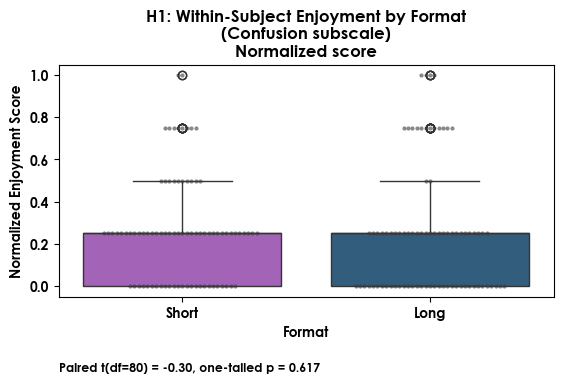

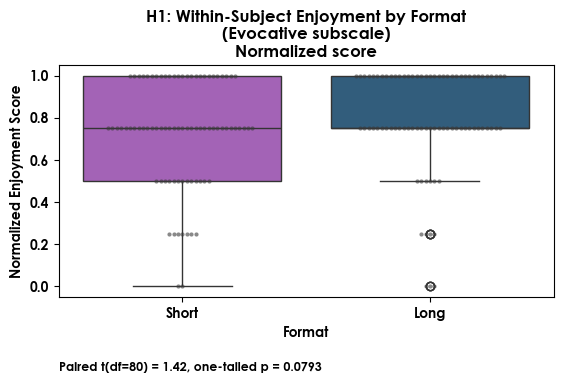

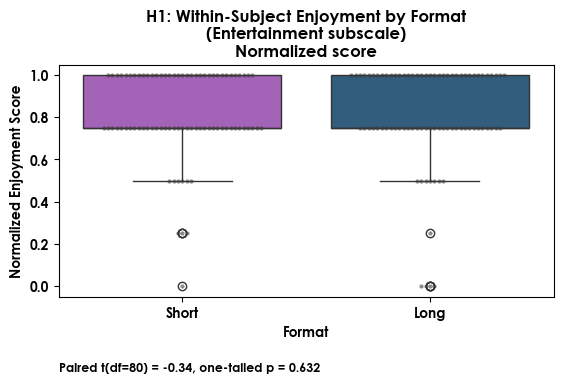

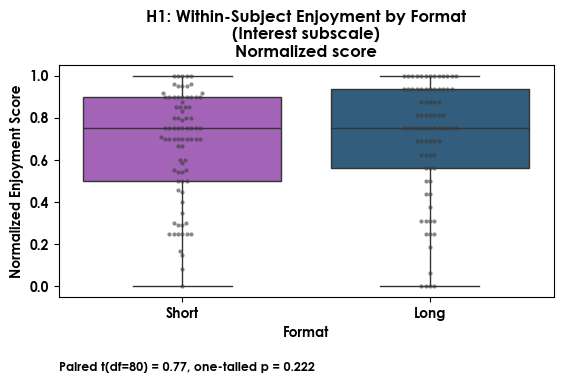

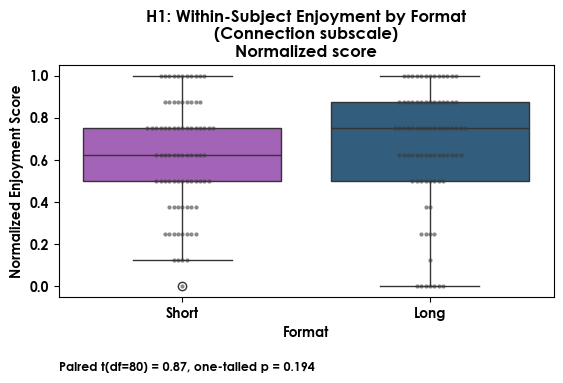

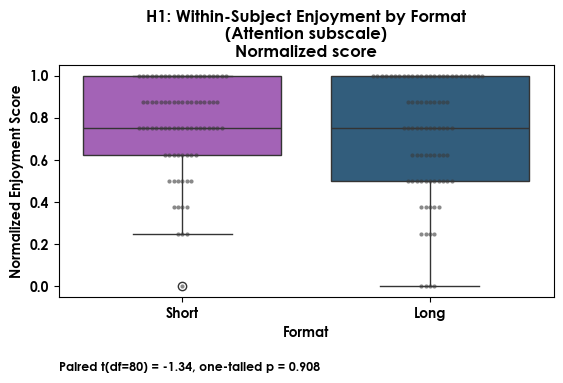

,subscale,n_paired,t_stat,df,p_one_tailed
0,Confusion,81,-0.298122,80,0.616808
1,Evocative,81,1.423136,80,0.079292
2,Entertainment,81,-0.338637,80,0.632115
3,Interest,81,0.770105,80,0.221753
4,Connection,81,0.869230,80,0.193661
5,Attention,81,-1.340126,80,0.908001


In [352]:
subscale_within_subject_summaries = []
for subscale in ENJOYMENT_SUBSCALES:
    metric_df = subscale_long.loc[subscale_long["subscale"] == subscale]
    if metric_df.empty:
        print(f"{subscale}: no normalized survey data available; skipping within-subject analysis.")
        continue
    respondent_means = metric_df.groupby([id_column, "form"], observed=True)["value"].mean().unstack()
    if not {"Short", "Long"}.issubset(respondent_means.columns):
        print(f"{subscale}: requires both Short and Long format data for paired comparison; skipping.")
        continue
    try:
        t_stat, df_val, p_one, paired = one_tailed_p_from_paired_t(respondent_means["Long"], respondent_means["Short"])
    except ValueError as exc:
        print(f"{subscale}: {exc}")
        continue
    subscale_within_subject_summaries.append({
        "subscale": subscale,
        "n_paired": paired.shape[0],
        "t_stat": t_stat,
        "df": df_val,
        "p_one_tailed": p_one,
    })
    plot_data = paired.reset_index().melt(id_vars=id_column, value_vars=["Short", "Long"], var_name="form", value_name="value")
    palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.3, right=0.95)
    sns.boxplot(data=plot_data, x="form", y="value", order=["Short", "Long"], hue="form", palette=palette, dodge=False, legend=False, ax=ax)
    sns.swarmplot(data=plot_data, x="form", y="value", order=["Short", "Long"], color="#3a3a3a", size=3, alpha=0.6, ax=ax)
    ax.set_title(f"H1: Within-Subject Enjoyment by Format\n({subscale} subscale)\nNormalized score")
    ax.set_xlabel("Format")
    ax.set_ylabel("Normalized Enjoyment Score")
    annotation = f"Paired t(df={df_val}) = {t_stat:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.28, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    plt.show()
pd.DataFrame(subscale_within_subject_summaries)

In [353]:
subscale_p_lookup = {row["subscale"]: row.get("p_one_tailed", np.nan) for row in subscale_within_subject_summaries} if 'subscale_within_subject_summaries' in globals() else {}
subscale_summary_rows = []
for subscale in ENJOYMENT_SUBSCALES:
    metric_df = subscale_long.loc[subscale_long["subscale"] == subscale]
    if metric_df.empty:
        continue
    respondent_means = metric_df.groupby([id_column, "form"], observed=True)["value"].mean().unstack()
    if respondent_means.empty or not {"Short", "Long"}.issubset(respondent_means.columns):
        continue
    long_mean = respondent_means["Long"].mean()
    short_mean = respondent_means["Short"].mean()
    diff = long_mean - short_mean
    p_val = subscale_p_lookup.get(subscale, np.nan)
    subscale_summary_rows.append({
        "Subscale": subscale,
        "Long mean": long_mean,
        "Short mean": short_mean,
        "Difference": diff,
        "p (one-tailed)": p_val,
        "n paired": respondent_means.dropna().shape[0],
    })
if subscale_summary_rows:
    subscale_summary = pd.DataFrame(subscale_summary_rows)
    display(to_percent_table(subscale_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
    overall_long = subscale_long.loc[subscale_long["form"] == "Long", "value"].mean()
    overall_short = subscale_long.loc[subscale_long["form"] == "Short", "value"].mean()
    sample_items = []
    overall_long_count = subscale_long.loc[subscale_long["form"] == "Long", id_column].nunique()
    overall_short_count = subscale_long.loc[subscale_long["form"] == "Short", id_column].nunique()
    if overall_long_count:
        sample_items.append(f"n_long={int(overall_long_count)}")
    if overall_short_count:
        sample_items.append(f"n_short={int(overall_short_count)}")
    extra_items = [", ".join(sample_items) if sample_items else None, "aggregate of normalized subscale scores"]
    extra_note = ", ".join(item for item in extra_items if item) or None
    print_long_short_summary(
        label="H1 Subscales (within-subject, all titles)",
        long_mean=overall_long,
        short_mean=overall_short,
        extra_note=extra_note
    )
else:
    print("H1 subscale within-subject summary: No paired data available.")

,Subscale,Long mean,Short mean,Difference,p (one-tailed),n paired
0,Confusion,25.9%,27.4%,-1.5%,0.616808,81
1,Evocative,78.7%,72.0%,6.8%,0.079292,81
2,Entertainment,79.6%,80.2%,-0.6%,0.632115,81
3,Interest,70.2%,66.3%,3.9%,0.221753,81
4,Connection,65.7%,61.3%,4.5%,0.193661,81
5,Attention,71.3%,76.1%,-4.8%,0.908001,81


H1 Subscales (within-subject, all titles): Long form (65%) showed 5% greater than short form (60%) (n_long=81, n_short=82, aggregate of normalized subscale scores).


Nostalgia: requires both formats for mixed model; skipping.


c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

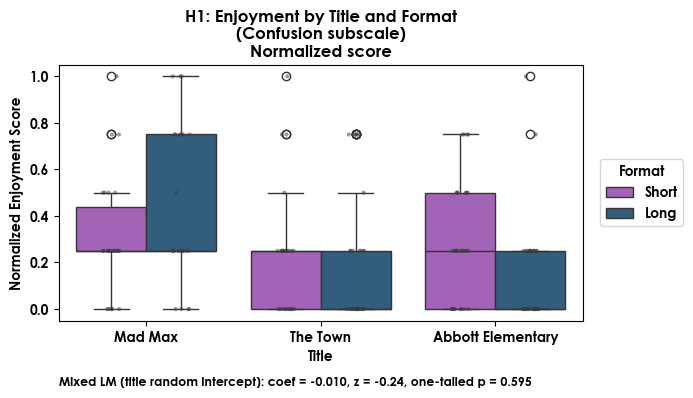

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

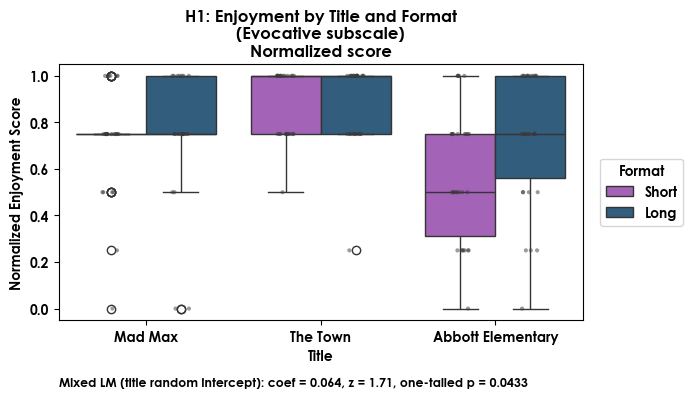

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

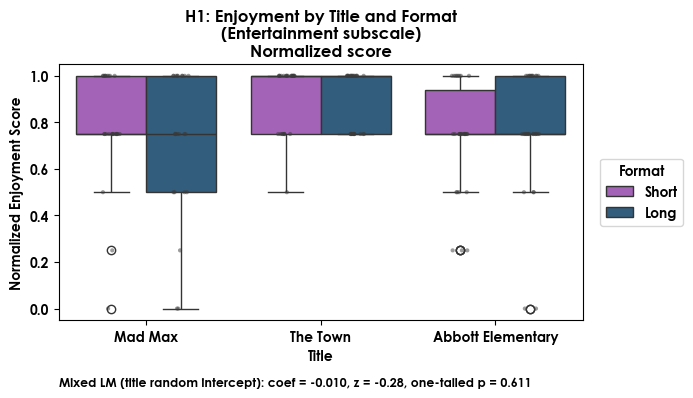

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

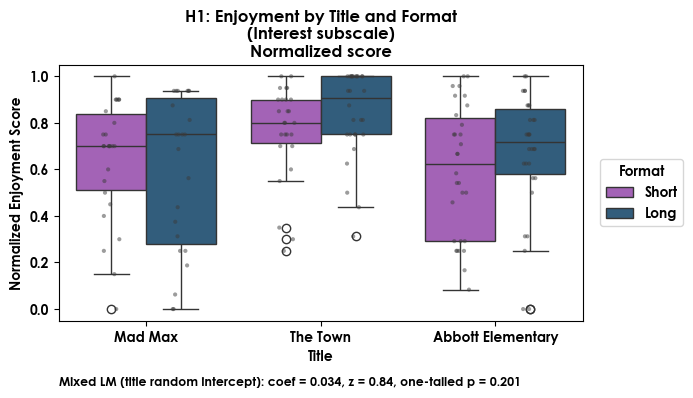

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

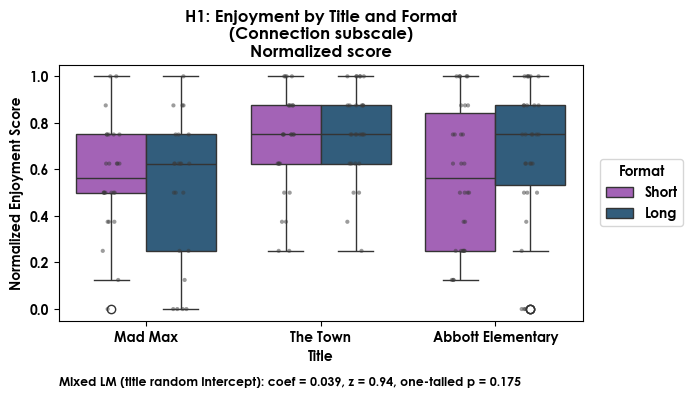

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

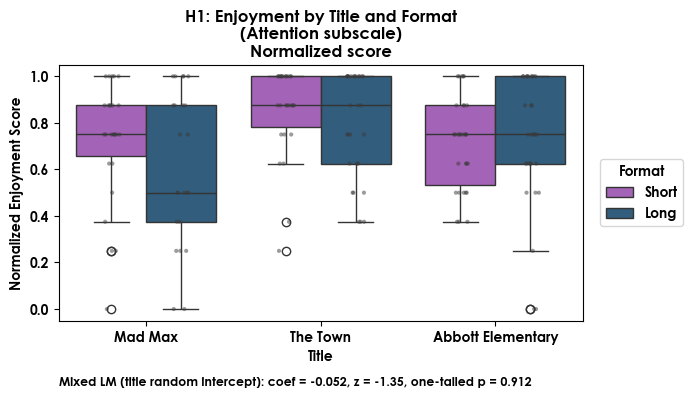

,subscale,coef_form_long,z_value,p_one_tailed,n_observations,titles_included
0,Confusion,-0.010353,-0.241576,0.595446,163,3
1,Evocative,0.063653,1.713354,0.043324,163,3
2,Entertainment,-0.009786,-0.280689,0.610526,163,3
3,Interest,0.033529,0.837503,0.201155,163,3
4,Connection,0.038714,0.935978,0.174642,163,3
5,Attention,-0.052244,-1.350308,0.911541,163,3


In [354]:
subscale_between_subject_summaries = []
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
for subscale in ENJOYMENT_SUBSCALES:
    subset = subscale_long.loc[
        (subscale_long["subscale"] == subscale)
        & (subscale_long["title"].isin(TARGET_TITLES))
    ].copy()
    if subset.empty:
        print(f"{subscale}: no normalized survey data available after filtering to target titles; skipping mixed model.")
        continue
    if subset["form"].nunique() < 2:
        print(f"{subscale}: requires both formats for mixed model; skipping.")
        continue
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
    except Exception as exc:
        print(f"Mixed model failed for {subscale} subscale: {exc}")
        continue
    coef = mixed_result.params.get("form_long", np.nan)
    se = mixed_result.bse.get("form_long", np.nan)
    z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
    p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    subscale_between_subject_summaries.append({
        "subscale": subscale,
        "coef_form_long": coef,
        "z_value": z_val,
        "p_one_tailed": p_one,
        "n_observations": subset.shape[0],
        "titles_included": subset["title"].nunique(),
    })
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.24, right=0.78)
    sns.boxplot(data=subset, x="title", y="value", hue="form", palette=palette, order=TARGET_TITLES, hue_order=["Short", "Long"], ax=ax)
    sns.stripplot(data=subset, x="title", y="value", hue="form", palette={"Short": "#3a3a3a", "Long": "#3a3a3a"}, order=TARGET_TITLES, hue_order=["Short", "Long"], dodge=True, size=3, alpha=0.5, ax=ax, legend=False)
    ax.set_title(f"H1: Enjoyment by Title and Format\n({subscale} subscale)\nNormalized score")
    ax.set_xlabel("Title")
    ax.set_ylabel("Normalized Enjoyment Score")
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
pd.DataFrame(subscale_between_subject_summaries)

In [355]:
between_lookup = {row["subscale"]: row for row in subscale_between_subject_summaries} if 'subscale_between_subject_summaries' in globals() else {}
subscale_between_rows = []
for subscale in ENJOYMENT_SUBSCALES:
    subset = subscale_long.loc[
        (subscale_long["subscale"] == subscale)
        & (subscale_long["title"].isin(TARGET_TITLES))
    ]
    if subset.empty:
        continue
    long_mean = subset.loc[subset["form"] == "Long", "value"].mean()
    short_mean = subset.loc[subset["form"] == "Short", "value"].mean()
    diff = long_mean - short_mean
    p_val = between_lookup.get(subscale, {}).get("p_one_tailed", np.nan)
    n_obs = subset.shape[0]
    subscale_between_rows.append({
        "Subscale": subscale,
        "Long mean": long_mean,
        "Short mean": short_mean,
        "Difference": diff,
        "p (one-tailed)": p_val,
        "n observations": n_obs,
    })
if subscale_between_rows:
    subscale_between_summary = pd.DataFrame(subscale_between_rows)
    display(to_percent_table(subscale_between_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
    overall_long = subscale_long.loc[
        (subscale_long["form"] == "Long") & (subscale_long["title"].isin(TARGET_TITLES)),
        "value",
    ].mean()
    overall_short = subscale_long.loc[
        (subscale_long["form"] == "Short") & (subscale_long["title"].isin(TARGET_TITLES)),
        "value",
    ].mean()
    sample_items = []
    long_count = subscale_long.loc[
        (subscale_long["form"] == "Long") & (subscale_long["title"].isin(TARGET_TITLES)),
        id_column,
    ].nunique()
    short_count = subscale_long.loc[
        (subscale_long["form"] == "Short") & (subscale_long["title"].isin(TARGET_TITLES)),
        id_column,
    ].nunique()
    if long_count:
        sample_items.append(f"n_long={int(long_count)}")
    if short_count:
        sample_items.append(f"n_short={int(short_count)}")
    extra_items = [", ".join(sample_items) if sample_items else None, "title-level mixed model summaries"]
    extra_note = ", ".join(item for item in extra_items if item) or None
    print_long_short_summary(
        label="H1 Subscales (between-subject, target titles)",
        long_mean=overall_long,
        short_mean=overall_short,
        extra_note=extra_note
    )
else:
    print("H1 subscale between-subject summary: No data available for target titles.")

,Subscale,Long mean,Short mean,Difference,p (one-tailed),n observations
0,Nostalgia,NA,36.0%,NA,NaN,82
1,Confusion,25.9%,27.4%,-1.5%,0.595446,163
2,Evocative,78.7%,72.0%,6.8%,0.043324,163
3,Entertainment,79.6%,80.2%,-0.6%,0.610526,163
4,Interest,70.2%,66.3%,3.9%,0.201155,163
5,Connection,65.7%,61.3%,4.5%,0.174642,163
6,Attention,71.3%,76.1%,-4.8%,0.911541,163


H1 Subscales (between-subject, target titles): Long form (65%) showed 5% greater than short form (60%) (n_long=81, n_short=82, title-level mixed model summaries).


### Subscale Item Counts
Different subscales sometimes include varying numbers of questions per respondent. The table below inventories the observed counts so we can explain scaling differences (e.g., higher sums arising from more answered items).

In [356]:
subscale_item_counts = []
for subscale in ENJOYMENT_SUBSCALES:
    count_pattern = re.compile(rf"^(Long|Short)_(.+?)_Survey_{re.escape(subscale)}_Count$")
    matched_columns = [col for col in uv.columns if count_pattern.match(col)]
    observed_counts = set()
    for column in matched_columns:
        values = uv[column].dropna()
        values = values[values > 0]
        if values.empty:
            continue
        observed_counts.update(values.astype(int).tolist())
    if observed_counts:
        counts_sorted = sorted(observed_counts)
        subscale_item_counts.append({
            "subscale": subscale,
            "question_count": counts_sorted[-1],
            "all_observed_counts": ", ".join(str(count) for count in counts_sorted),
        })
    else:
        subscale_item_counts.append({
            "subscale": subscale,
            "question_count": np.nan,
            "all_observed_counts": "No data",
        })
subscale_item_table = pd.DataFrame(subscale_item_counts).sort_values("subscale").reset_index(drop=True)
subscale_item_table

,subscale,question_count,all_observed_counts
0,Attention,2,2
1,Confusion,1,1
2,Connection,2,2
3,Entertainment,1,1
4,Evocative,1,1
5,Interest,6,"4, 5, 6"
6,Nostalgia,1,1


## Hypothesis 2 - Format and Recall
:We test whether long-form presentations yield stronger post-recognition performance than short-form presentations for the three target titles. Stage 3 composites are normalised to a 0–1 scale prior to analysis so that formats share a comparable envelope, and results are surfaced through both distributional plots and mean-level bar charts, mirroring the H1 workflow.

### Part 1: Normalized Within-Subject Comparison
We extract the `Long_key_Post_Recognition_Mean` and `Short_key_Post_Recognition_Mean` composites, rescale them to a shared 0–1 envelope, and apply the paired, one-tailed t-test used in H1 (expecting Long > Short). Visuals include the familiar box/swarn layout plus a companion mean-only bar chart so the normalised uplift is easy to reference in summaries.

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 16.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


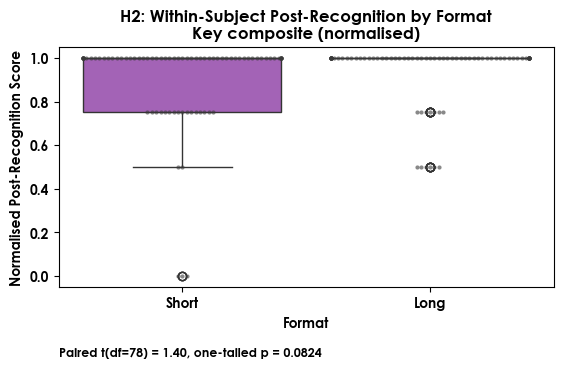

C:\Users\ashra\AppData\Local\Temp\ipykernel_31296\3230230711.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bar_data, x="form", y="value", order=["Short", "Long"], palette=[palette["Short"], palette["Long"]], ax=ax_bar)


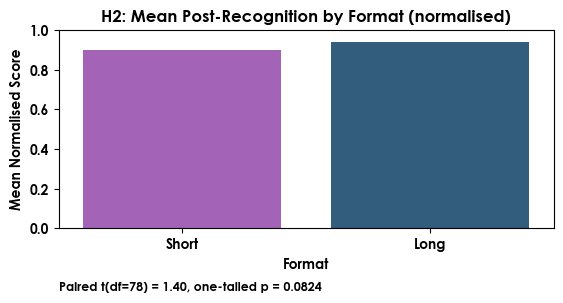

(    form  mean_normalised  std_normalised   n
 0   Long         0.939873        0.145527  79
 1  Short         0.898734        0.217500  79,
                             metric  n_paired    t_stat  df  p_one_tailed  \
 0  Post_Recognition_Key_Normalised        79  1.402244  78      0.082405   
 
    mean_long  mean_short  
 0   0.939873    0.898734  )

In [357]:
RECOGNITION_METRICS = {
    "Long": "Long_key_Post_Recognition_Mean",
    "Short": "Short_key_Post_Recognition_Mean",
}
recognition_columns = list(RECOGNITION_METRICS.values())
recognition_base = (
    uv[[id_column, "Short Form", "Long Form"] + recognition_columns]
    .dropna(subset=recognition_columns, how="any")
    .copy()
)
recognition_base = recognition_base.rename(columns={"Short Form": "short_title", "Long Form": "long_title"})
recognition_base[id_column] = recognition_base[id_column].astype(str)
value_min = recognition_base[recognition_columns].to_numpy().min()
value_max = recognition_base[recognition_columns].to_numpy().max()
if not np.isfinite(value_min) or not np.isfinite(value_max):
    raise ValueError("Recognition metrics contain non-finite values and cannot be normalised.")
if value_max == value_min:
    raise ValueError("Recognition metrics have zero variance; min-max normalisation is undefined.")
range_span = value_max - value_min
recognition_normalised = recognition_base.copy()
# Shared min-max scaling keeps both formats on the same 0-1 frame
recognition_normalised.loc[:, recognition_columns] = (
    recognition_normalised.loc[:, recognition_columns] - value_min
) / range_span
recognition_normalised.loc[:, recognition_columns] = recognition_normalised.loc[:, recognition_columns].clip(0.0, 1.0)
paired_norm = recognition_normalised.rename(columns={
    RECOGNITION_METRICS["Long"]: "Long",
    RECOGNITION_METRICS["Short"]: "Short",
})
t_stat, df_val, p_one, paired_table = one_tailed_p_from_paired_t(paired_norm["Long"], paired_norm["Short"])
plot_data = paired_norm[[id_column, "Short", "Long"]].melt(
    id_vars=id_column,
    value_vars=["Short", "Long"],
    var_name="form",
    value_name="value",
)
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(bottom=0.28, right=0.95)
sns.boxplot(data=plot_data, x="form", y="value", order=["Short", "Long"], hue="form", palette=palette, dodge=False, legend=False, ax=ax)
sns.swarmplot(data=plot_data, x="form", y="value", order=["Short", "Long"], color="#3a3a3a", size=3, alpha=0.6, ax=ax)
ax.set_title("H2: Within-Subject Post-Recognition by Format\nKey composite (normalised)")
ax.set_xlabel("Format")
ax.set_ylabel("Normalised Post-Recognition Score")
annotation = f"Paired t(df={df_val}) = {t_stat:.2f}, one-tailed p = {p_one:.3g}"
ax.text(0.0, -0.25, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
plt.show()
bar_data = (
    plot_data.groupby("form", observed=True)["value"].mean().reindex(["Short", "Long"]).reset_index()
)
fig_bar, ax_bar = plt.subplots(figsize=(6, 3.2))
fig_bar.subplots_adjust(bottom=0.26, right=0.95)
sns.barplot(data=bar_data, x="form", y="value", order=["Short", "Long"], palette=[palette["Short"], palette["Long"]], ax=ax_bar)
ax_bar.set_ylim(0, 1.0)
ax_bar.set_xlabel("Format")
ax_bar.set_ylabel("Mean Normalised Score")
ax_bar.set_title("H2: Mean Post-Recognition by Format (normalised)")
ax_bar.text(0.0, -0.27, annotation, transform=ax_bar.transAxes, ha="left", va="top", fontsize=9)
plt.show()
recognition_descriptives = (
    plot_data.groupby("form", observed=True)["value"]
    .agg(["mean", "std", "count"])
    .rename(columns={"mean": "mean_normalised", "std": "std_normalised", "count": "n"})
    .reset_index()
)
recognition_summary = pd.DataFrame([
    {
        "metric": "Post_Recognition_Key_Normalised",
        "n_paired": paired_table.shape[0],
        "t_stat": t_stat,
        "df": df_val,
        "p_one_tailed": p_one,
        "mean_long": paired_table["Long"].mean(),
        "mean_short": paired_table["Short"].mean(),
    }
])
recognition_long = (
    paired_norm[[id_column, "short_title", "long_title", "Short", "Long"]]
    .melt(
        id_vars=[id_column, "short_title", "long_title"],
        value_vars=["Short", "Long"],
        var_name="form",
        value_name="value",
    )
)
recognition_long["title"] = np.where(
    recognition_long["form"] == "Long",
    recognition_long["long_title"],
    recognition_long["short_title"],
)
recognition_long = recognition_long.drop(columns=["short_title", "long_title"]).dropna(subset=["value"])
recognition_long[id_column] = recognition_long[id_column].astype(str)
recognition_long["form"] = pd.Categorical(recognition_long["form"], categories=["Short", "Long"], ordered=True)
recognition_long["title"] = recognition_long["title"].astype(str)
recognition_descriptives, recognition_summary

In [358]:
if 'paired_norm' in globals():
    long_mean = paired_norm["Long"].mean()
    short_mean = paired_norm["Short"].mean()
    diff = long_mean - short_mean
    n_pairs = paired_norm.dropna(subset=["Long", "Short"]).shape[0]
    h2_part1_summary = pd.DataFrame([
        {
            "Metric": "Key Post-Recognition (normalised)",
            "Long mean": long_mean,
            "Short mean": short_mean,
            "Difference": diff,
            "p (one-tailed)": p_one if 'p_one' in globals() else np.nan,
            "n paired": n_pairs,
        }
    ])
    display(to_percent_table(h2_part1_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
    extra_items = []
    p_val = p_one if 'p_one' in globals() else None
    if isinstance(p_val, Number) and np.isfinite(p_val):
        extra_items.append(format_p_value(p_val))
    if isinstance(n_pairs, Number) and np.isfinite(n_pairs) and n_pairs:
        extra_items.append(f"n_pairs={int(n_pairs)}")
    extra_note = ", ".join(extra_items) if extra_items else None
    print_long_short_summary(
        label="H2 Part 1 (Key composite)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H2 Part 1 summary: paired_norm not available.")

,Metric,Long mean,Short mean,Difference,p (one-tailed),n paired
0,Key Post-Recognition (normalised),94.0%,89.9%,4.1%,0.082405,79


H2 Part 1 (Key composite): Long form (94%) showed 4% greater than short form (90%) (p=0.082, n_pairs=79).


### Part 2: Mixed Models by Title
We filter the normalised key composite to the three target titles, fit a mixed-effects model with title as a random intercept, and present both distributional and mean bar charts to document the Long–Short lift at the title level. Model annotations mirror H1 so the effect size and one-tailed p-value sit alongside the visuals.

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

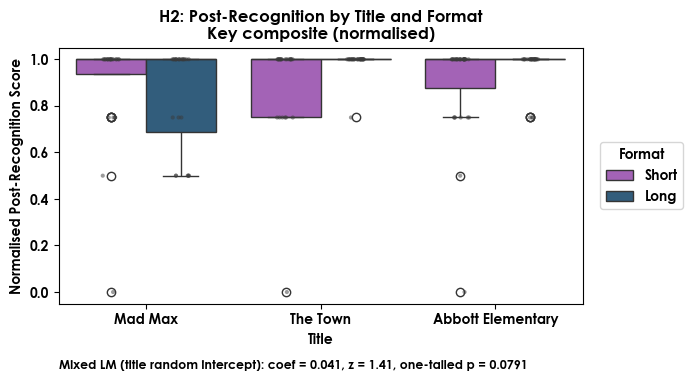

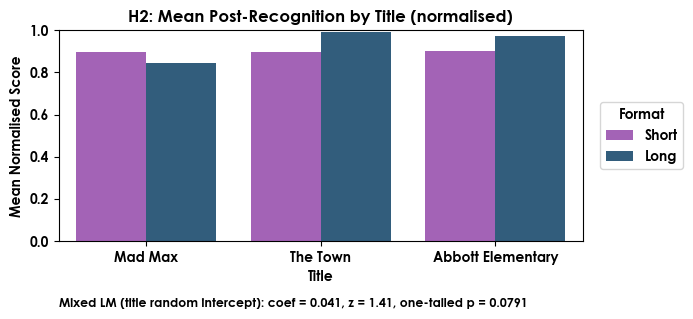

(               title   form  mean_normalised  std_normalised   n
 0  Abbott Elementary  Short         0.903226        0.210925  31
 1  Abbott Elementary   Long         0.972222        0.080064  27
 2            Mad Max  Short         0.895833        0.232153  24
 3            Mad Max   Long         0.843750        0.218847  24
 4           The Town  Short         0.895833        0.220137  24
 5           The Town   Long         0.991071        0.047246  28,
                             metric  coef_form_long   z_value  p_one_tailed  \
 0  Post_Recognition_Key_Normalised        0.040694  1.411163      0.079098   
 
    n_observations  titles_included  
 0             158                3  )

In [359]:
recognition_between_subject_summary = []
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}
subset = recognition_long.loc[recognition_long["title"].isin(TARGET_TITLES)].copy()
if subset.empty:
    print("No post-recognition records available for the specified target titles.")
    recognition_title_descriptives = pd.DataFrame()
    recognition_title_summary = pd.DataFrame()
else:
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
        coef = mixed_result.params.get("form_long", np.nan)
        se = mixed_result.bse.get("form_long", np.nan)
        z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
        p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    except Exception as exc:
        print(f"Mixed model failed: {exc}")
        coef = se = z_val = p_one = np.nan
    recognition_between_subject_summary.append({
        "metric": "Post_Recognition_Key_Normalised",
        "coef_form_long": coef,
        "z_value": z_val,
        "p_one_tailed": p_one,
        "n_observations": subset.shape[0],
        "titles_included": subset["title"].nunique(),
    })
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.24, right=0.78)
    sns.boxplot(
        data=subset,
        x="title",
        y="value",
        hue="form",
        palette=palette,
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        ax=ax,
    )
    sns.stripplot(
        data=subset,
        x="title",
        y="value",
        hue="form",
        palette={"Short": "#3a3a3a", "Long": "#3a3a3a"},
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        dodge=True,
        size=3,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("Title")
    ax.set_ylabel("Normalised Post-Recognition Score")
    ax.set_title("H2: Post-Recognition by Title and Format\nKey composite (normalised)")
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
    bar_data_title = (
        subset.groupby(["title", "form"], observed=True)["value"]
        .mean()
        .reset_index(name="mean_value")
    )
    # Ensure that every title-format combination is represented for consistent ordering
    bar_data_title = bar_data_title.set_index(["title", "form"]).reindex(
        pd.MultiIndex.from_product([TARGET_TITLES, ["Short", "Long"]], names=["title", "form"])
    ).reset_index()
    fig_bar, ax_bar = plt.subplots(figsize=(8, 3.4))
    fig_bar.subplots_adjust(bottom=0.26, right=0.78)
    sns.barplot(
        data=bar_data_title,
        x="title",
        y="mean_value",
        hue="form",
        palette=palette,
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        ax=ax_bar,
    )
    ax_bar.set_ylim(0, 1.0)
    ax_bar.set_xlabel("Title")
    ax_bar.set_ylabel("Mean Normalised Score")
    ax_bar.set_title("H2: Mean Post-Recognition by Title (normalised)")
    ax_bar.text(0.0, -0.27, annotation, transform=ax_bar.transAxes, ha="left", va="top", fontsize=9)
    ax_bar.legend(title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
    recognition_title_summary = pd.DataFrame(recognition_between_subject_summary)
    recognition_title_descriptives = (
        subset.groupby(["title", "form"], observed=True)["value"]
        .agg(["mean", "std", "count"])
        .rename(columns={"mean": "mean_normalised", "std": "std_normalised", "count": "n"})
        .reset_index()
    )
recognition_title_descriptives, recognition_title_summary

In [360]:
if 'recognition_long' in globals():
    title_rows = []
    for title in TARGET_TITLES:
        title_df = recognition_long.loc[recognition_long["title"] == title]
        if title_df.empty:
            continue
        long_vals = title_df.loc[title_df["form"] == "Long", "value"].dropna()
        short_vals = title_df.loc[title_df["form"] == "Short", "value"].dropna()
        if long_vals.empty or short_vals.empty:
            continue
        long_mean = long_vals.mean()
        short_mean = short_vals.mean()
        diff = long_mean - short_mean
        t_stat, p_two = stats.ttest_ind(long_vals, short_vals, equal_var=False, nan_policy="omit")
        if np.isnan(t_stat) or np.isnan(p_two):
            p_one = np.nan
        else:
            if t_stat >= 0:
                p_one = p_two / 2
            else:
                p_one = 1 - (p_two / 2)
        title_rows.append({
            "Title": title,
            "Long mean": long_mean,
            "Short mean": short_mean,
            "Difference": diff,
            "p (one-tailed, title)": p_one,
            "n Long": int(long_vals.count()),
            "n Short": int(short_vals.count()),
        })
    if title_rows:
        h2_part2_summary = pd.DataFrame(title_rows)
        display(to_percent_table(h2_part2_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
        overall_p = recognition_between_subject_summary[0]["p_one_tailed"] if recognition_between_subject_summary else np.nan
        for row in title_rows:
            overall_note = None
            if isinstance(overall_p, Number) and np.isfinite(overall_p):
                overall_note = f"overall mixed-model {format_p_value(overall_p)}"
            sample_note = f"n_long={row['n Long']}, n_short={row['n Short']}"
            extra = ", ".join(filter(None, [format_p_value(row.get("p (one-tailed, title)")), sample_note, overall_note]))
            print_long_short_summary(
                label=f"H2 Part 2 – {row['Title']} (Key composite)",
                long_mean=row["Long mean"],
                short_mean=row["Short mean"],
                extra_note=extra
            )
        combined_long = h2_part2_summary["Long mean"].mean()
        combined_short = h2_part2_summary["Short mean"].mean()
        overall_counts = {
            "n_long": int(recognition_long.loc[recognition_long["form"] == "Long", "value"].notna().sum()),
            "n_short": int(recognition_long.loc[recognition_long["form"] == "Short", "value"].notna().sum()),
        }
        sample_note = f"n_long={overall_counts['n_long']}, n_short={overall_counts['n_short']}"
        extra = ", ".join(filter(None, [format_p_value(overall_p), sample_note]))
        print_long_short_summary(
            label="H2 Part 2 (Overall Key composite)",
            long_mean=combined_long,
            short_mean=combined_short,
            extra_note=extra
        )
    else:
        print("H2 Part 2 summary: No title-level data available.")
else:
    print("H2 Part 2 summary: recognition_long not available.")

,Title,Long mean,Short mean,Difference,"p (one-tailed, title)",n Long,n Short
0,Mad Max,84.4%,89.6%,-5.2%,0.786010,24,24
1,The Town,99.1%,89.6%,9.5%,0.024064,28,24
2,Abbott Elementary,97.2%,90.3%,6.9%,0.049735,27,31


H2 Part 2 – Mad Max (Key composite): Long form (84%) showed 5% lower than short form (90%) (p=0.786, n_long=24, n_short=24, overall mixed-model p=0.079).
H2 Part 2 – The Town (Key composite): Long form (99%) showed 10% greater than short form (90%) (p=0.024, n_long=28, n_short=24, overall mixed-model p=0.079).
H2 Part 2 – Abbott Elementary (Key composite): Long form (97%) showed 7% greater than short form (90%) (p=0.050, n_long=27, n_short=31, overall mixed-model p=0.079).
H2 Part 2 (Overall Key composite): Long form (94%) showed 4% greater than short form (90%) (p=0.079, n_long=79, n_short=79).


#### Part 2a/2b: Component Breakdown (Binary vs Confidence)
We rerun the title-level comparison separately for the binary recognition hits (`Q1-1`/`Q4-1`) and the confidence multipliers (`Q1-2`/`Q4-2`), averaging across the available key-moment prompts before fitting the same mixed model and rendering paired box/strip and mean bar plots.

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

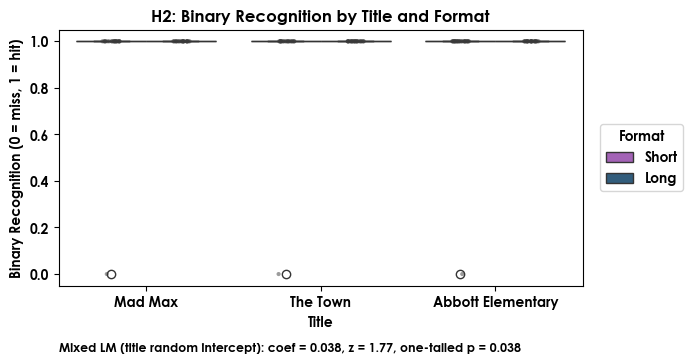

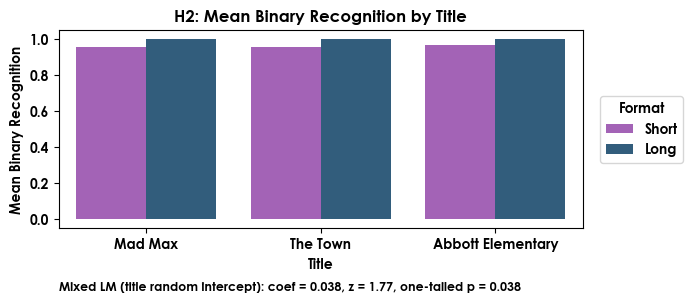

c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\ashra\Documents\NeuralSense\NeuralData\clients\544_WBD_CXCU\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\ashra\Documents\NeuralSense\NeuralDat

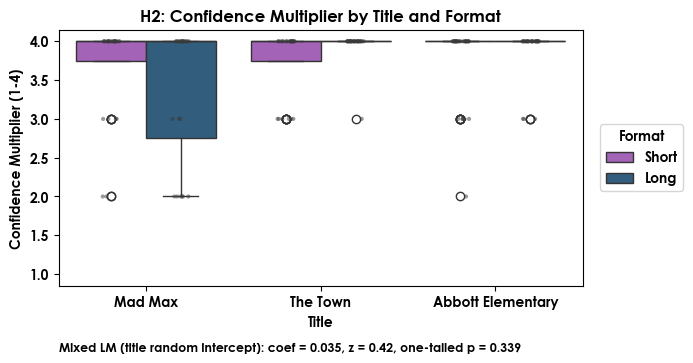

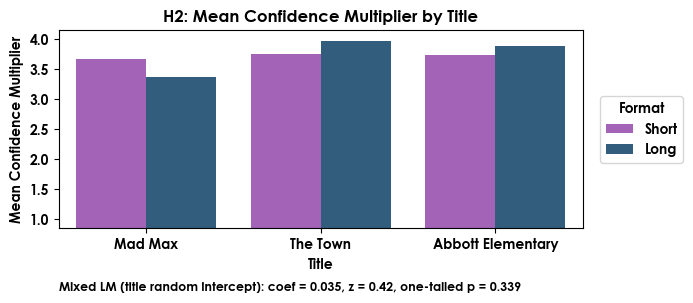

(                      component              title   form      mean       std  \
 0  Binary Recognition Hits (Q1)            Mad Max  Short  0.958333  0.204124   
 1  Binary Recognition Hits (Q1)            Mad Max   Long  1.000000  0.000000   
 2  Binary Recognition Hits (Q1)           The Town  Short  0.958333  0.204124   
 3  Binary Recognition Hits (Q1)           The Town   Long  1.000000  0.000000   
 4  Binary Recognition Hits (Q1)  Abbott Elementary  Short  0.967742  0.179605   
 5  Binary Recognition Hits (Q1)  Abbott Elementary   Long  1.000000  0.000000   
 
    count  
 0     24  
 1     24  
 2     24  
 3     28  
 4     31  
 5     27  ,
                       component  coef_form_long   z_value  p_one_tailed  \
 0  Binary Recognition Hits (Q1)        0.038217  1.774132      0.038021   
 
    n_observations  titles_included  
 0             158                3  ,
                     component              title   form      mean       std  \
 0  Confidence Multiplier (Q

In [392]:
from collections import defaultdict

component_pattern = re.compile(r"^(Long|Short)_(.+?)_Post_Recognition_Q([14])-(\d)$")
component_columns = {
    "binary": defaultdict(list),
    "multiplier": defaultdict(list),
}
for col in uv.columns:
    match = component_pattern.match(col)
    if not match:
        continue
    form, title, question, component_code = match.groups()
    title = title.strip()
    component_key = "binary" if component_code == "1" else "multiplier"
    component_columns[component_key][(form, title)].append(col)

component_metadata = {
    "binary": {
        "label": "Binary Recognition Hits (Q1)",
        "title": "H2: Binary Recognition by Title and Format",
        "bar_title": "H2: Mean Binary Recognition by Title",
        "ylabel": "Binary Recognition (0 = miss, 1 = hit)",
        "bar_ylabel": "Mean Binary Recognition",
        "scale_hint": (0.0, 1.0),
    },
    "multiplier": {
        "label": "Confidence Multiplier (Q2)",
        "title": "H2: Confidence Multiplier by Title and Format",
        "bar_title": "H2: Mean Confidence Multiplier by Title",
        "ylabel": "Confidence Multiplier (1-4)",
        "bar_ylabel": "Mean Confidence Multiplier",
        "scale_hint": (1.0, 4.0),
    },
}

component_title_descriptives = {}
component_title_summary = {}
palette = {"Short": COLOR_MAP["Short"], "Long": COLOR_MAP["Long"]}

for component_key, combo_map in component_columns.items():
    frames = []
    for (form, title), cols in combo_map.items():
        available = [col for col in cols if col in uv.columns]
        if not available:
            continue
        title_column = "Long Form" if form == "Long" else "Short Form"
        relevant_rows = uv.loc[uv[title_column] == title, [id_column] + available].copy()
        if relevant_rows.empty:
            continue
        relevant_rows[id_column] = relevant_rows[id_column].astype(str)
        relevant_rows["value"] = relevant_rows[available].mean(axis=1, skipna=True)
        relevant_rows = relevant_rows.dropna(subset=["value"])
        if relevant_rows.empty:
            continue
        frames.append(
            relevant_rows[[id_column, "value"]].assign(form=form, title=title)
        )
    component_long = (
        pd.concat(frames, ignore_index=True)
        if frames
        else pd.DataFrame(columns=[id_column, "form", "title", "value"])
    )
    component_long = component_long.loc[component_long["title"].isin(TARGET_TITLES)].copy()
    if component_long.empty:
        print(f"No component data available for {component_key}.")
        component_title_descriptives[component_key] = pd.DataFrame()
        component_title_summary[component_key] = pd.DataFrame()
        continue
    component_long["form"] = pd.Categorical(component_long["form"], categories=["Short", "Long"], ordered=True)
    component_long["title"] = pd.Categorical(component_long["title"], categories=TARGET_TITLES, ordered=True)
    subset = component_long.copy()
    subset["form_long"] = (subset["form"] == "Long").astype(int)
    try:
        mixed_model = smf.mixedlm("value ~ form_long", data=subset, groups=subset["title"])
        mixed_result = mixed_model.fit(reml=False, method="lbfgs", disp=False)
        coef = mixed_result.params.get("form_long", np.nan)
        se = mixed_result.bse.get("form_long", np.nan)
        z_val = coef / se if np.isfinite(se) and se != 0 else np.nan
        p_one = stats.norm.sf(z_val) if np.isfinite(z_val) else np.nan
    except Exception as exc:
        print(f"{component_key.title()} mixed model failed: {exc}")
        coef = se = z_val = p_one = np.nan
    meta = component_metadata[component_key]
    component_title_summary[component_key] = pd.DataFrame([
        {
            "component": meta["label"],
            "coef_form_long": coef,
            "z_value": z_val,
            "p_one_tailed": p_one,
            "n_observations": subset.shape[0],
            "titles_included": subset["title"].nunique(),
        }
    ])
    descriptives = (
        subset.groupby(["title", "form"], observed=True)["value"]
        .agg(mean="mean", std="std", count="count")
        .reset_index()
    )
    descriptives.insert(0, "component", meta["label"])
    component_title_descriptives[component_key] = descriptives
    value_min = subset["value"].min()
    value_max = subset["value"].max()
    if not np.isfinite(value_min) or not np.isfinite(value_max):
        value_min, value_max = meta["scale_hint"]
    scale_low, scale_high = meta["scale_hint"]
    lower = min(value_min, scale_low)
    upper = max(value_max, scale_high)
    if not np.isfinite(lower) or not np.isfinite(upper):
        lower, upper = scale_low, scale_high
    margin = 0.05 * (upper - lower if upper > lower else 1.0)
    ylim = (lower - margin, upper + margin)
    fig, ax = plt.subplots(figsize=(8, 4))
    fig.subplots_adjust(bottom=0.24, right=0.78)
    sns.boxplot(
        data=subset,
        x="title",
        y="value",
        hue="form",
        palette=palette,
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        ax=ax,
    )
    sns.stripplot(
        data=subset,
        x="title",
        y="value",
        hue="form",
        palette={"Short": "#3a3a3a", "Long": "#3a3a3a"},
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        dodge=True,
        size=3,
        alpha=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("Title")
    ax.set_ylabel(meta["ylabel"])
    ax.set_title(meta["title"])
    ax.set_ylim(*ylim)
    annotation = f"Mixed LM (title random intercept): coef = {coef:.3f}, z = {z_val:.2f}, one-tailed p = {p_one:.3g}"
    ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
    bar_data_title = (
        subset.groupby(["title", "form"], observed=True)["value"]
        .mean()
        .reset_index(name="mean_value")
    )
    bar_index = pd.MultiIndex.from_product([TARGET_TITLES, ["Short", "Long"]], names=["title", "form"])
    bar_data_title = (
        bar_data_title
        .set_index(["title", "form"])
        .reindex(bar_index)
        .reset_index()
    )
    fig_bar, ax_bar = plt.subplots(figsize=(8, 3.2))
    fig_bar.subplots_adjust(bottom=0.26, right=0.78)
    sns.barplot(
        data=bar_data_title,
        x="title",
        y="mean_value",
        hue="form",
        palette=palette,
        order=TARGET_TITLES,
        hue_order=["Short", "Long"],
        ax=ax_bar,
    )
    ax_bar.set_xlabel("Title")
    ax_bar.set_ylabel(meta["bar_ylabel"])
    ax_bar.set_title(meta["bar_title"])
    ax_bar.set_ylim(*ylim)
    ax_bar.text(0.0, -0.27, annotation, transform=ax_bar.transAxes, ha="left", va="top", fontsize=9)
    ax_bar.legend(title="Format", loc="center left", bbox_to_anchor=(1.02, 0.5))
    plt.show()
binary_title_descriptives = component_title_descriptives.get("binary", pd.DataFrame())
binary_title_summary = component_title_summary.get("binary", pd.DataFrame())
multiplier_title_descriptives = component_title_descriptives.get("multiplier", pd.DataFrame())
multiplier_title_summary = component_title_summary.get("multiplier", pd.DataFrame())
binary_title_descriptives, binary_title_summary, multiplier_title_descriptives, multiplier_title_summary

In [393]:
component_summary_rows = []
for component_key, descriptives in component_title_descriptives.items():
    if descriptives is None or descriptives.empty:
        continue
    label = component_title_summary.get(component_key, pd.DataFrame()).get("component", [component_key]).iloc[0] if component_key in component_title_summary else component_key
    long_mean = descriptives.loc[descriptives["form"] == "Long", "mean"].mean()
    short_mean = descriptives.loc[descriptives["form"] == "Short", "mean"].mean()
    diff = long_mean - short_mean
    summary_entry = component_title_summary.get(component_key)
    p_val = summary_entry["p_one_tailed"].iloc[0] if summary_entry is not None and not summary_entry.empty else np.nan
    n_obs = descriptives["count"].sum()
    component_summary_rows.append({
        "Component": label,
        "Long mean": long_mean,
        "Short mean": short_mean,
        "Difference": diff,
        "p (one-tailed)": p_val,
        "responses": n_obs,
    })
if component_summary_rows:
    component_summary = pd.DataFrame(component_summary_rows)
    display(to_percent_table(component_summary, ["Long mean", "Short mean", "Difference"], decimals=1))
    preferred_row = next((row for row in component_summary_rows if "Binary" in row["Component"]), component_summary_rows[0])
    extra_items = []
    p_val = preferred_row.get("p (one-tailed)")
    if isinstance(p_val, Number) and np.isfinite(p_val):
        extra_items.append(format_p_value(p_val))
    responses_val = preferred_row.get("responses")
    if isinstance(responses_val, Number) and np.isfinite(responses_val) and responses_val:
        extra_items.append(f"responses={int(responses_val)}")
    extra_note = ", ".join(extra_items) if extra_items else None
    print_long_short_summary(
        label=f"H2 Part 2a/2b ({preferred_row['Component']})",
        long_mean=preferred_row["Long mean"],
        short_mean=preferred_row["Short mean"],
        extra_note=extra_note
)
    binary_label = "Binary Recognition Hits (Q1)"
    if "component" in binary_title_descriptives.columns and not binary_title_descriptives["component"].dropna().empty:
        binary_label = binary_title_descriptives["component"].dropna().iloc[0]
    metric_column = None
    if 'recognition_long' in globals() and isinstance(recognition_long, pd.DataFrame):
        for candidate in ("metric", "component", "question"):
            if candidate in recognition_long.columns:
                metric_column = candidate
                break
    try:
        from statsmodels.stats.proportion import proportions_ztest
    except Exception:
        proportions_ztest = None
    binary_title_rows = []
    if isinstance(binary_title_descriptives, pd.DataFrame) and not binary_title_descriptives.empty:
        if 'TARGET_TITLES' in globals():
            title_order = [title for title in TARGET_TITLES if title in binary_title_descriptives["title"].unique()]
        else:
            title_order = []
        extra_titles = [title for title in binary_title_descriptives["title"].unique() if title not in title_order]
        title_order.extend(sorted(extra_titles))
        for title in title_order:
            title_rows = binary_title_descriptives.loc[binary_title_descriptives["title"] == title]
            if title_rows.empty:
                continue
            long_row = title_rows.loc[title_rows["form"] == "Long"]
            short_row = title_rows.loc[title_rows["form"] == "Short"]
            long_mean = float(long_row["mean"].iloc[0]) if not long_row.empty else np.nan
            short_mean = float(short_row["mean"].iloc[0]) if not short_row.empty else np.nan
            diff = long_mean - short_mean
            long_count = int(long_row["count"].iloc[0]) if not long_row.empty else 0
            short_count = int(short_row["count"].iloc[0]) if not short_row.empty else 0
            long_successes = int(round(long_mean * long_count)) if long_count else 0
            short_successes = int(round(short_mean * short_count)) if short_count else 0
            p_one = np.nan
            if proportions_ztest is not None and long_count > 0 and short_count > 0:
                try:
                    _, p_prop = proportions_ztest(
                        [long_successes, short_successes],
                        [long_count, short_count],
                        alternative="larger"
)
                    if np.isfinite(p_prop):
                        p_one = float(np.clip(p_prop, 0.0, 1.0))
                except Exception:
                    p_one = np.nan
            if (not isinstance(p_one, Number)) or not np.isfinite(p_one):
                if metric_column and 'recognition_long' in globals():
                    subset = recognition_long.loc[
                        (recognition_long[metric_column] == binary_label) &
                        (recognition_long["title"] == title)
                    ]
                    long_vals = subset.loc[subset["form"] == "Long", "value"].dropna()
                    short_vals = subset.loc[subset["form"] == "Short", "value"].dropna()
                    if len(long_vals) >= 2 and len(short_vals) >= 2:
                        t_stat, p_two = stats.ttest_ind(long_vals, short_vals, equal_var=False, nan_policy="omit")
                        if np.isfinite(p_two):
                            p_one = p_two / 2.0
                            if diff < 0:
                                p_one = 1 - p_one
                            if np.isfinite(p_one):
                                p_one = float(np.clip(p_one, 0.0, 1.0))
            binary_title_rows.append({
                "Title": title,
                "Long mean": long_mean,
                "Short mean": short_mean,
                "Difference": diff,
                "p (one-tailed)": p_one,
                "n_long": long_count,
                "n_short": short_count,
            })
    if binary_title_rows:
        binary_title_table = pd.DataFrame(binary_title_rows)
        display_table = to_percent_table(binary_title_table.copy(), ["Long mean", "Short mean", "Difference"], decimals=1)
        display_table["p (one-tailed)"] = display_table["p (one-tailed)"].apply(format_p_value)
        for col in ["n_long", "n_short"]:
            display_table[col] = display_table[col].apply(lambda x: "" if pd.isna(x) else int(x))
        display(display_table[["Title", "Long mean", "Short mean", "Difference", "p (one-tailed)", "n_long", "n_short"]])
        overall_binary_row = preferred_row if preferred_row["Component"] == binary_label else next((row for row in component_summary_rows if row["Component"] == binary_label), None)
        overall_note = None
        if overall_binary_row:
            overall_p = overall_binary_row.get("p (one-tailed)")
            if isinstance(overall_p, Number) and np.isfinite(overall_p):
                overall_note = f"overall mixed-model {format_p_value(overall_p)}"
        for row in binary_title_table.to_dict("records"):
            extra_bits = []
            p_val = row.get("p (one-tailed)")
            if isinstance(p_val, Number) and np.isfinite(p_val):
                extra_bits.append(format_p_value(p_val))
            if row.get("n_long"):
                extra_bits.append(f"n_long={int(row['n_long'])}")
            if row.get("n_short"):
                extra_bits.append(f"n_short={int(row['n_short'])}")
            if overall_note:
                extra_bits.append(overall_note)
            extra_note_title = ", ".join(extra_bits) if extra_bits else None
            print_long_short_summary(
                label=f"H2 Part 2a/2b – {row['Title']} ({binary_label})",
                long_mean=row["Long mean"],
                short_mean=row["Short mean"],
                extra_note=extra_note_title
)
else:
    print("H2 Part 2a/2b summary: No component data available for target titles.")

,Component,Long mean,Short mean,Difference,p (one-tailed),responses
0,Binary Recognition Hits (Q1),100.0%,96.1%,3.9%,0.038021,158
1,Confidence Multiplier (Q2),374.3%,372.0%,2.3%,0.338845,158


H2 Part 2a/2b (Binary Recognition Hits (Q1)): Long form (100%) showed 4% greater than short form (96%) (p=0.038, responses=158).


,Title,Long mean,Short mean,Difference,p (one-tailed),n_long,n_short
0,Mad Max,100.0%,95.8%,4.2%,p=0.156,24,24
1,The Town,100.0%,95.8%,4.2%,p=0.138,28,24
2,Abbott Elementary,100.0%,96.8%,3.2%,p=0.173,27,31


H2 Part 2a/2b – Mad Max (Binary Recognition Hits (Q1)): Long form (100%) showed 4% greater than short form (96%) (p=0.156, n_long=24, n_short=24, overall mixed-model p=0.038).
H2 Part 2a/2b – The Town (Binary Recognition Hits (Q1)): Long form (100%) showed 4% greater than short form (96%) (p=0.138, n_long=28, n_short=24, overall mixed-model p=0.038).
H2 Part 2a/2b – Abbott Elementary (Binary Recognition Hits (Q1)): Long form (100%) showed 3% greater than short form (97%) (p=0.173, n_long=27, n_short=31, overall mixed-model p=0.038).


### Part 3: Category-Level Recognition Means
We expand the recall analysis to the broader recognition categories and plot the normalised means with standard-error bars so lifts across question types are easy to compare.

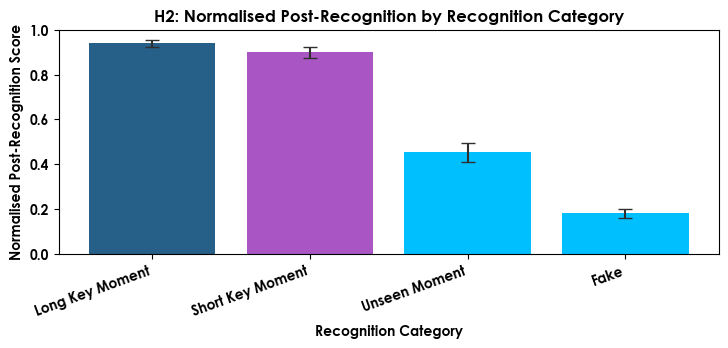

,category_label,mean,std,count,sem
0,Long Key Moment,0.939873,0.145527,79,0.016373
1,Short Key Moment,0.898734,0.217500,79,0.024471
2,Unseen Moment,0.452532,0.388282,79,0.043685
3,Fake,0.181171,0.184429,79,0.020750


In [394]:
category_spec = [
    ("Long_key_Post_Recognition_Mean", "Long Key Moment"),
    ("Short_key_Post_Recognition_Mean", "Short Key Moment"),
    ("distractor_Post_Recognition_Mean", "Distractor Key Moment"),
    ("Long_seen_Post_Recognition_Mean", "Long Non-key Seen"),
    ("distractor2_Post_Recognition_Mean", "Distractor Non-key Seen"),
    ("unseen_Post_Recognition_Mean", "Long Unseen"),
    ("fake_Post_Recognition_Mean", "Unseen"),
]

category_spec = [
    ("Long_key_Post_Recognition_Mean", "Long Key Moment"),
    ("Short_key_Post_Recognition_Mean", "Short Key Moment"),
    ("unseen_Post_Recognition_Mean", "Unseen Moment"),
    ("fake_Post_Recognition_Mean", "Fake"),
]

available_spec = [(col, label) for col, label in category_spec if col in uv.columns]
if not available_spec:
    raise ValueError("No recognition category columns found for Part 3 bar chart.")
category_columns = [col for col, _ in available_spec]
label_order = [label for _, label in available_spec]
category_df = uv[[id_column] + category_columns].copy()
category_df[id_column] = category_df[id_column].astype(str)
category_df = category_df.dropna(subset=category_columns, how="all")
if category_df.empty:
    raise ValueError("Recognition category data is empty after dropping missing rows.")
category_values = category_df[category_columns].to_numpy(dtype=float)
if np.isnan(category_values).all():
    raise ValueError("Recognition category metrics are all NaN and cannot be normalised.")
value_min = np.nanmin(category_values)
value_max = np.nanmax(category_values)
if not np.isfinite(value_min) or not np.isfinite(value_max):
    raise ValueError("Recognition category metrics contain non-finite values and cannot be normalised.")
if np.isclose(value_max, value_min):
    raise ValueError("Recognition category metrics have zero variance; min-max normalisation is undefined.")
normalised_values = (category_values - value_min) / (value_max - value_min)
normalised_values = np.clip(normalised_values, 0.0, 1.0)
category_norm = pd.DataFrame(normalised_values, columns=category_columns, index=category_df.index)
category_norm.insert(0, id_column, category_df[id_column])
reverse_columns = {
    "unseen_Post_Recognition_Mean": "Long Unseen",
    "fake_Post_Recognition_Mean": "Unseen",
}
for col in reverse_columns:
    if col in category_norm.columns:
        category_norm.loc[:, col] = 1.0 - category_norm[col]
category_long = category_norm.melt(id_vars=id_column, var_name="category", value_name="value").dropna(subset=["value"])
category_long["category_label"] = pd.Categorical(
    category_long["category"].map(dict(available_spec)),
    categories=label_order,
    ordered=True,
 )
category_long = category_long.dropna(subset=["category_label"])
summary = (
    category_long.groupby("category_label", observed=True)["value"]
    .agg(mean="mean", std="std", count="count")
    .reindex(label_order)
    .reset_index()
 )
summary["sem"] = summary["std"] / np.sqrt(summary["count"].replace(0, np.nan))
summary["sem"] = summary["sem"].fillna(0.0)
x = np.arange(summary.shape[0])
fig, ax = plt.subplots(figsize=(8, 4))
fig.subplots_adjust(bottom=0.32, right=0.95)
label_list = summary["category_label"].tolist()
bar_colors = []
for label in label_list:
    if "Long" in label:
        bar_colors.append(COLOR_MAP.get("Long", "#265f88"))
    elif "Short" in label:
        bar_colors.append(COLOR_MAP.get("Short", "#aa55c4"))
    else:
        bar_colors.append(COLOR_MAP.get("Default", "#1f77b4"))
ax.bar(x, summary["mean"], color=bar_colors)
ax.errorbar(x, summary["mean"], yerr=summary["sem"], fmt="none", ecolor="#2f2f2f", capsize=5, linewidth=1.5)
ax.set_xticks(x)
ax.set_xticklabels(label_list, rotation=20, ha="right")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Normalised Post-Recognition Score")
ax.set_xlabel("Recognition Category")
ax.set_title("H2: Normalised Post-Recognition by Recognition Category")
plt.show()
summary

In [395]:
if 'summary' in globals():
    category_table = summary.rename(columns={
        "category_label": "Category",
        "mean": "Mean",
        "sem": "SEM",
        "count": "n",
    })[["Category", "Mean", "SEM", "n"]]
    display(to_percent_table(category_table, ["Mean", "SEM"], decimals=1))
    long_rows = summary[summary["category_label"].str.contains("Long", case=False, na=False)]
    short_rows = summary[summary["category_label"].str.contains("Short", case=False, na=False)]
    long_mean = long_rows["mean"].mean() if not long_rows.empty else np.nan
    short_mean = short_rows["mean"].mean() if not short_rows.empty else np.nan
    respondent_count = category_norm[id_column].nunique() if 'category_norm' in globals() else None
    extra_items = ["category means averaged across Long/Short labels"]
    if respondent_count:
        extra_items.insert(0, f"respondents={int(respondent_count)}")
    extra_note = ", ".join(extra_items) if extra_items else None
    print_long_short_summary(
        label="H2 Part 3 (Normalised recognition categories)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H2 Part 3 summary: category summary not available.")

,Category,Mean,SEM,n
0,Long Key Moment,94.0%,1.6%,79
1,Short Key Moment,89.9%,2.4%,79
2,Unseen Moment,45.3%,4.4%,79
3,Fake,18.1%,2.1%,79


H2 Part 3 (Normalised recognition categories): Long form (94%) showed 4% greater than short form (90%) (respondents=79, category means averaged across Long/Short labels).


## Hypothesis 3 – Familiarity and Enjoyment
We extend the workflow to test whether higher title familiarity predicts stronger enjoyment responses. Familiarity is sourced from the screening C1 scores, normalised onto a 0–1 scale so that titles and formats share a comparable envelope. Enjoyment uses the normalized, polarity-corrected composite built in H1.

In [396]:
FAMILIARITY_METRIC = "Screening_Familiarity_C1"
ENJOYMENT_METRIC = "EnjoymentComposite_NormalizedCorrected"
fam_pattern = re.compile(rf"^(Long|Short)_(.+?)_{re.escape(FAMILIARITY_METRIC)}$")
fam_frames = []
for column in uv.columns:
    match = fam_pattern.match(column)
    if not match:
        continue
    form, title_token = match.groups()
    title_clean = title_token.replace("_", " ").strip()
    frame = (
        uv[[id_column, column]]
        .rename(columns={column: "familiarity_raw"})
        .assign(form=form, title=title_clean)
    )
    fam_frames.append(frame)
if not fam_frames:
    raise ValueError("No familiarity columns matching the expected Screening_C1 pattern were found in uv_merged.csv.")
familiarity_long = (
    pd.concat(fam_frames, ignore_index=True)
    .dropna(subset=["familiarity_raw"])
)
familiarity_long[id_column] = familiarity_long[id_column].astype(str)
familiarity_long["form"] = pd.Categorical(familiarity_long["form"], categories=["Short", "Long"], ordered=True)
familiarity_min = familiarity_long["familiarity_raw"].min()
familiarity_max = familiarity_long["familiarity_raw"].max()
if not np.isfinite(familiarity_min) or not np.isfinite(familiarity_max):
    raise ValueError("Familiarity scores contain non-finite values and cannot be normalised.")
if np.isclose(familiarity_max, familiarity_min):
    raise ValueError("Familiarity scores have zero variance; min-max normalisation is undefined.")
familiarity_range = familiarity_max - familiarity_min
familiarity_long["familiarity_norm"] = (
    (familiarity_long["familiarity_raw"] - familiarity_min) / familiarity_range
).clip(0.0, 1.0)
enjoyment_metric_df = enjoyment_long.loc[enjoyment_long["metric"] == ENJOYMENT_METRIC].copy()
if enjoyment_metric_df.empty:
    raise ValueError("Enjoyment composite for H3 (NormalisedCorrected) is unavailable in enjoyment_long.")
enjoyment_metric_df = enjoyment_metric_df.rename(columns={"value": "enjoyment_norm"})
h3_base = (
    familiarity_long.merge(
        enjoyment_metric_df[[id_column, "form", "title", "enjoyment_norm"]],
        on=[id_column, "form", "title"],
        how="inner",
    )
    .dropna(subset=["familiarity_norm", "enjoyment_norm"])
)
h3_base["title"] = h3_base["title"].astype(str)
h3_base_summary = h3_base.groupby(["form", "title"], observed=True).size().rename("records").reset_index()
h3_base_summary.head()

,form,title,records
0,Short,Abbott Elementary,30
1,Short,Mad Max,26
2,Short,The Town,26
3,Long,Abbott Elementary,30
4,Long,Mad Max,23


### Part 1: Overall Familiarity–Enjoyment Association
We pool all formats and titles to quantify the overall link between normalised familiarity and enjoyment. The analysis reports the Pearson correlation alongside a scatterplot with a fitted trend line.

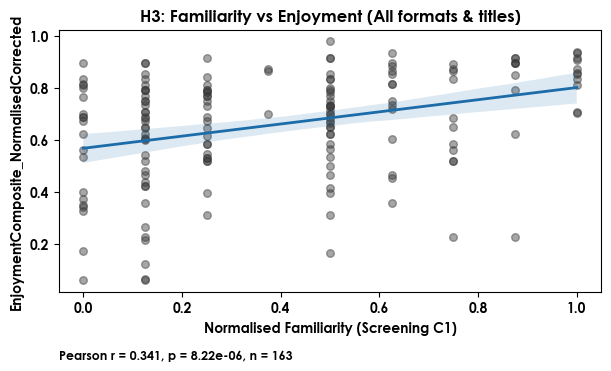

,group,pearson_r,p_value,n
0,All formats and titles,0.341359,0.000008,163


In [397]:
if h3_base.empty:
    raise ValueError("No overlapping familiarity and enjoyment records available for H3 analysis.")
overall_df = h3_base.copy()
if overall_df["familiarity_norm"].nunique() < 2 or overall_df["enjoyment_norm"].nunique() < 2:
    raise ValueError("Familiarity or enjoyment lacks sufficient variance for correlation analysis in Part 1.")
r_val, p_val = stats.pearsonr(overall_df["familiarity_norm"], overall_df["enjoyment_norm"])
fig, ax = plt.subplots(figsize=(6.5, 4.3))
fig.subplots_adjust(bottom=0.27, right=0.96)
sns.regplot(
    data=overall_df,
    x="familiarity_norm",
    y="enjoyment_norm",
    scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
    line_kws={"color": "#1b6ca8", "linewidth": 2},
    ax=ax,
)
ax.set_xlabel("Normalised Familiarity (Screening C1)")
ax.set_ylabel("EnjoymentComposite_NormalisedCorrected")
ax.set_title("H3: Familiarity vs Enjoyment (All formats & titles)")
annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {overall_df.shape[0]}"
ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
plt.show()
part1_summary = pd.DataFrame([
    {
        "group": "All formats and titles",
        "pearson_r": r_val,
        "p_value": p_val,
        "n": overall_df.shape[0],
    }
])
part1_summary

In [398]:
if 'overall_df' in globals():
    h3_part1_table = pd.DataFrame([
        {
            "Pearson r": r_val if 'r_val' in globals() else np.nan,
            "p-value": p_val if 'p_val' in globals() else np.nan,
            "n": overall_df.shape[0],
        }
    ])
    h3_part1_table["p-value"] = h3_part1_table["p-value"].apply(format_p_value)
    display(h3_part1_table)
    long_mean = overall_df.loc[overall_df["form"] == "Long", "enjoyment_norm"].mean()
    short_mean = overall_df.loc[overall_df["form"] == "Short", "enjoyment_norm"].mean()
    extra_items = []
    if 'r_val' in globals() and isinstance(r_val, Number) and np.isfinite(r_val):
        extra_items.append(f"Pearson r={r_val:.3f}")
    if 'p_val' in globals() and isinstance(p_val, Number) and np.isfinite(p_val):
        extra_items.append(format_p_value(p_val))
    extra_items.append(f"n={overall_df.shape[0]}")
    extra_note = ", ".join(extra_items)
    print_long_short_summary(
        label="H3 Part 1 (All formats)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H3 Part 1 summary: overall_df not available.")

,Pearson r,p-value,n
0,0.341359,p<0.001,163


H3 Part 1 (All formats): Long form (68%) showed 4% greater than short form (64%) (Pearson r=0.341, p<0.001, n=163).


### Part 2: Correlations by Format
Correlations are recomputed separately for Long and Short formats while keeping all titles in play. Points and trend lines share the same axis so format differences are immediately visible.

(  format  pearson_r   p_value   n
 0  Short   0.460318  0.000014  82
 1   Long   0.240916  0.030268  81,
   format     slope                          test   p_value
 0  Short  0.307311  Interaction slope difference  0.167521
 1   Long  0.166810  Interaction slope difference  0.167521,
                             sum_sq     df          F    PR(>F)
 C(form)                   0.046691    1.0   1.228325  0.269407
 familiarity_norm          0.797988    1.0  20.992919  0.000009
 familiarity_norm:C(form)  0.073079    1.0   1.922514  0.167521
 Residual                  6.043951  159.0        NaN       NaN)

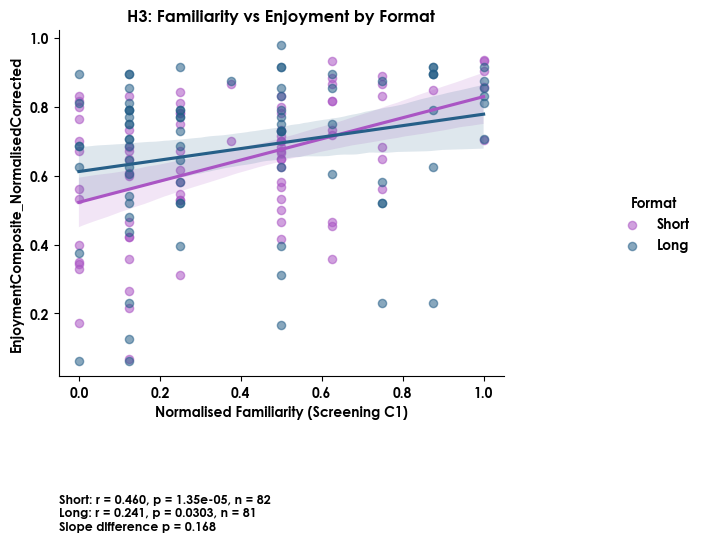

In [399]:
from statsmodels.stats.anova import anova_lm
format_palette = {"Short": COLOR_MAP.get("Short", "#aa55c4"), "Long": COLOR_MAP.get("Long", "#265f88")}
format_summaries = []
for form, subset in overall_df.groupby("form", observed=True):
    subset = subset.dropna(subset=["familiarity_norm", "enjoyment_norm"])
    if subset.shape[0] < 3 or subset["familiarity_norm"].nunique() < 2 or subset["enjoyment_norm"].nunique() < 2:
        r_form = np.nan
        p_form = np.nan
    else:
        r_form, p_form = stats.pearsonr(subset["familiarity_norm"], subset["enjoyment_norm"])
    format_summaries.append({
        "format": form,
        "pearson_r": r_form,
        "p_value": p_form,
        "n": subset.shape[0],
    })
format_model = smf.ols("enjoyment_norm ~ familiarity_norm * C(form)", data=overall_df).fit()
format_anova = anova_lm(format_model, typ=2)
baseline_slope = format_model.params.get("familiarity_norm", np.nan)
interaction_term = "familiarity_norm:C(form)[T.Long]"
interaction_coef = format_model.params.get(interaction_term, np.nan)
long_slope = baseline_slope + interaction_coef if np.isfinite(baseline_slope) and np.isfinite(interaction_coef) else np.nan
format_slope_table = pd.DataFrame([
    {
        "format": "Short",
        "slope": baseline_slope,
    },
    {
        "format": "Long",
        "slope": long_slope,
    },
]).assign(test="Interaction slope difference", p_value=format_model.pvalues.get(interaction_term, np.nan))
format_plot = sns.lmplot(
    data=overall_df,
    x="familiarity_norm",
    y="enjoyment_norm",
    hue="form",
    palette=format_palette,
    scatter_kws={"alpha": 0.55, "s": 35},
    height=4.2,
    aspect=1.25,
    legend=False,
)
format_plot.ax.set_xlabel("Normalised Familiarity (Screening C1)")
format_plot.ax.set_ylabel("EnjoymentComposite_NormalisedCorrected")
format_plot.ax.set_title("H3: Familiarity vs Enjoyment by Format")
annotation_lines = [
    "{}: r = {}, p = {}, n = {}".format(
        row["format"],
        _fmt_stat(row["pearson_r"], "{:.3f}"),
        _fmt_stat(row["p_value"], "{:.3g}"),
        row["n"],
    )
    for row in format_summaries
]
interaction_text = f"Slope difference p = {_fmt_stat(format_model.pvalues.get(interaction_term, np.nan), '{:.3g}')}"
annotation_lines.append(interaction_text)
format_plot.ax.text(0.0, -0.34, "\n".join(annotation_lines), transform=format_plot.ax.transAxes, ha="left", va="top", fontsize=9)
format_plot.add_legend(title="Format", bbox_to_anchor=(1.02, 0.5), loc="center left")
format_summary = pd.DataFrame(format_summaries)
format_summary, format_slope_table, format_anova

In [400]:
if 'format_summary' in globals():
    formatted_summary = format_summary.copy()
    formatted_summary["pearson_r"] = formatted_summary["pearson_r"].round(3)
    formatted_summary["p_value"] = formatted_summary["p_value"].apply(format_p_value)
    display(formatted_summary.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'format_model' in globals():
        interaction_term = "familiarity_norm:C(form)[T.Long]"
        interaction_p = format_model.pvalues.get(interaction_term, np.nan)
        if np.isfinite(interaction_p):
            interaction_note = f"Slope diff {format_p_value(interaction_p)}"
    long_mean = overall_df.loc[overall_df["form"] == "Long", "enjoyment_norm"].mean() if 'overall_df' in globals() else np.nan
    short_mean = overall_df.loc[overall_df["form"] == "Short", "enjoyment_norm"].mean() if 'overall_df' in globals() else np.nan
    sample_items = []
    if not format_summary.empty:
        long_row = format_summary.loc[format_summary["format"] == "Long", "n"]
        short_row = format_summary.loc[format_summary["format"] == "Short", "n"]
        if not long_row.empty and isinstance(long_row.iloc[0], Number) and np.isfinite(long_row.iloc[0]):
            sample_items.append(f"n_long={int(long_row.iloc[0])}")
        if not short_row.empty and isinstance(short_row.iloc[0], Number) and np.isfinite(short_row.iloc[0]):
            sample_items.append(f"n_short={int(short_row.iloc[0])}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="H3 Part 2 (By format)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H3 Part 2 summary: format_summary not available.")

,format,Pearson r,p-value,n
0,Short,0.460,p<0.001,82
1,Long,0.241,p=0.030,81


H3 Part 2 (By format): Long form (68%) showed 4% greater than short form (64%) (n_long=81, n_short=82, Slope diff p=0.168).


### Part 3: Correlations by Title
Finally we focus on the target titles, pooling formats while colour-coding titles on a single axis. This highlights whether familiarity–enjoyment alignment differs across narratives.

(               title  pearson_r   p_value   n
 0  Abbott Elementary   0.544268  0.000007  60
 1            Mad Max   0.219080  0.130429  49
 2           The Town   0.387674  0.003775  54,
                title     slope                        test   p_value
 0  Abbott Elementary  0.343193              Baseline slope       NaN
 1            Mad Max  0.200000  Slope vs Abbott Elementary  0.263333
 2           The Town  0.189455  Slope vs Abbott Elementary  0.160346,
                                                       sum_sq     df  \
 C(title, Treatment(reference='Abbott Elementary'))  0.889595    2.0   
 familiarity_norm                                    1.053410    1.0   
 familiarity_norm:C(title, Treatment(reference='...  0.082100    2.0   
 Residual                                            5.192025  157.0   
 
                                                             F        PR(>F)  
 C(title, Treatment(reference='Abbott Elementary'))  13.450097  4.059018e-06  
 familiari

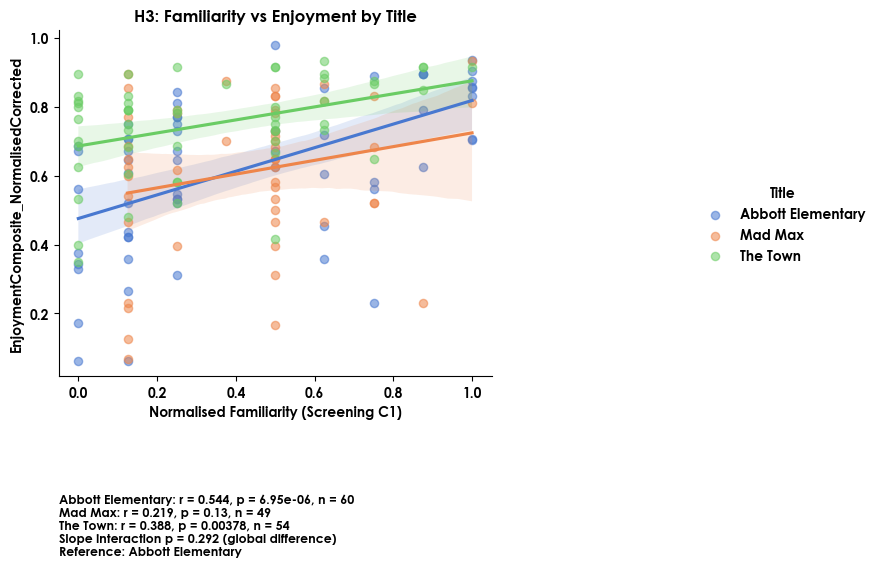

In [401]:
from statsmodels.stats.anova import anova_lm
title_subset = h3_base.loc[h3_base["title"].isin(TARGET_TITLES)].copy()
if title_subset.empty:
    print("No familiarity/enjoyment overlap for the specified target titles; skipping Part 3 plot.")
    title_summary = pd.DataFrame()
    title_slope_table = pd.DataFrame()
    title_anova = pd.DataFrame()
else:
    unique_titles = sorted(title_subset["title"].unique())
    reference_title = unique_titles[0]
    title_palette = dict(zip(unique_titles, sns.color_palette("muted", n_colors=len(unique_titles))))
    title_summaries = []
    for title_name, subset in title_subset.groupby("title", observed=True):
        subset = subset.dropna(subset=["familiarity_norm", "enjoyment_norm"])
        if subset.shape[0] < 3 or subset["familiarity_norm"].nunique() < 2 or subset["enjoyment_norm"].nunique() < 2:
            r_title = np.nan
            p_title = np.nan
        else:
            r_title, p_title = stats.pearsonr(subset["familiarity_norm"], subset["enjoyment_norm"])
        title_summaries.append({
            "title": title_name,
            "pearson_r": r_title,
            "p_value": p_title,
            "n": subset.shape[0],
        })
    title_model = smf.ols(
        f"enjoyment_norm ~ familiarity_norm * C(title, Treatment(reference='{reference_title}'))",
        data=title_subset,
    ).fit()
    title_anova = anova_lm(title_model, typ=2)
    slope_entries = []
    base_slope = title_model.params.get("familiarity_norm", np.nan)
    slope_entries.append({
        "title": reference_title,
        "slope": base_slope,
        "test": "Baseline slope",
        "p_value": np.nan,
    })
    for other in unique_titles[1:]:
        param_name = f"familiarity_norm:C(title, Treatment(reference='{reference_title}'))[T.{other}]"
        interaction_coef = title_model.params.get(param_name, np.nan)
        slope_val = base_slope + interaction_coef if np.isfinite(base_slope) and np.isfinite(interaction_coef) else np.nan
        slope_entries.append({
            "title": other,
            "slope": slope_val,
            "test": f"Slope vs {reference_title}",
            "p_value": title_model.pvalues.get(param_name, np.nan),
        })
    interaction_rows = [idx for idx in title_anova.index if idx.startswith("familiarity_norm:C(title, Treatment(")]
    interaction_p = title_anova.loc[interaction_rows[0], "PR(>F)"] if interaction_rows else np.nan
    title_slope_table = pd.DataFrame(slope_entries)
    title_plot = sns.lmplot(
        data=title_subset,
        x="familiarity_norm",
        y="enjoyment_norm",
        hue="title",
        palette=title_palette,
        scatter_kws={"alpha": 0.55, "s": 35},
        height=4.2,
        aspect=1.25,
        legend=False,
)
    title_plot.ax.set_xlabel("Normalised Familiarity (Screening C1)")
    title_plot.ax.set_ylabel("EnjoymentComposite_NormalisedCorrected")
    title_plot.ax.set_title("H3: Familiarity vs Enjoyment by Title")
    annotation_lines = [
        "{}: r = {}, p = {}, n = {}".format(
            row["title"],
            _fmt_stat(row["pearson_r"], "{:.3f}"),
            _fmt_stat(row["p_value"], "{:.3g}"),
            row["n"],
        )
        for row in title_summaries
]
    annotation_lines.append(
        f"Slope interaction p = {_fmt_stat(interaction_p, '{:.3g}')} (global difference)\nReference: {reference_title}"
    )
    title_plot.ax.text(0.0, -0.34, "\n".join(annotation_lines), transform=title_plot.ax.transAxes, ha="left", va="top", fontsize=9)
    title_plot.add_legend(title="Title", bbox_to_anchor=(1.02, 0.5), loc="center left")
    title_summary = pd.DataFrame(title_summaries)
title_summary, title_slope_table, title_anova

In [402]:
if 'title_summary' in globals() and not title_summary.empty:
    formatted_title_summary = title_summary.copy()
    formatted_title_summary["pearson_r"] = formatted_title_summary["pearson_r"].round(3)
    formatted_title_summary["p_value"] = formatted_title_summary["p_value"].apply(format_p_value)
    display(formatted_title_summary.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'title_anova' in globals() and not title_anova.empty:
        interaction_rows = [idx for idx in title_anova.index if idx.startswith("familiarity_norm:C(")]
        if interaction_rows:
            interaction_note = f"Global slope diff {format_p_value(title_anova.loc[interaction_rows[0], 'PR(>F)'])}"
    note_parts = []
    if not title_summary.empty:
        top_positive_idx = title_summary['pearson_r'].idxmax()
        top_positive = title_summary.loc[top_positive_idx]
        note_parts.append(
            f"Strongest positive correlation: {top_positive['title']} (r={top_positive['pearson_r']:.3f}, n={int(top_positive['n'])})"
        )
        significant_titles = title_summary.loc[title_summary['p_value'] < 0.05, 'title'].tolist()
        if significant_titles:
            note_parts.append(
                "Significant titles: " + ", ".join(significant_titles)
            )
    if interaction_note:
        note_parts.append(interaction_note)
    else:
        note_parts.append("Global slope diff unavailable")
    print("H3 Part 3 (By title): " + "; ".join(note_parts))
else:
    print("H3 Part 3 summary: title-level correlation results unavailable.")

,title,Pearson r,p-value,n
0,Abbott Elementary,0.544,p<0.001,60
1,Mad Max,0.219,p=0.130,49
2,The Town,0.388,p=0.004,54


H3 Part 3 (By title): Strongest positive correlation: Abbott Elementary (r=0.544, n=60); Significant titles: Abbott Elementary, The Town; Global slope diff p=0.292


### Part 4: Title-Level Format Comparison
We summarise how familiarity links to enjoyment within each title by plotting the Pearson correlations for Long and Short formats side-by-side. Bars encode the correlation coefficients, bar-level annotations flag significant slopes, and a curly-brace callout highlights whether the Long–Short slopes differ significantly. Significance codes: `**` for p ≤ 0.001, `*` for 0.001 < p ≤ 0.05.

(               title   form  pearson_r   p_value   n
 0  Abbott Elementary   Long   0.483819  0.006752  30
 1  Abbott Elementary  Short   0.592053  0.000568  30
 2            Mad Max   Long  -0.066751  0.762185  23
 3            Mad Max  Short   0.594422  0.001363  26
 4           The Town   Long   0.462885  0.013123  28
 5           The Town  Short   0.334396  0.094980  26,
                title  delta_p_value
 0  Abbott Elementary       0.673792
 1            Mad Max       0.026093
 2           The Town       0.840844)

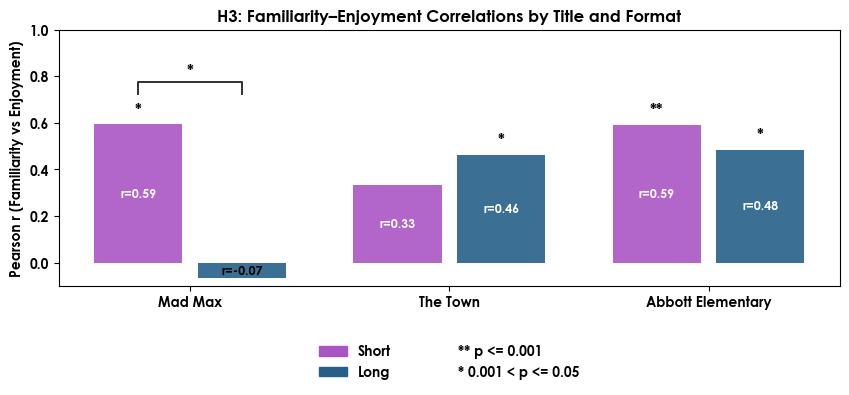

In [403]:
def significance_label(p_value: float) -> str:
    if not np.isfinite(p_value):
        return ""
    if p_value <= 0.001:
        return "**"
    if p_value <= 0.05:
        return "*"
    return ""


title_correlation_records = []
title_difference_records = []
for title_name, title_df in h3_base.groupby("title", observed=True):
    for form_name, form_df in title_df.groupby("form", observed=True):
        form_df = form_df.dropna(subset=["familiarity_norm", "enjoyment_norm"])
        if form_df.shape[0] < 3 or form_df["familiarity_norm"].nunique() < 2 or form_df["enjoyment_norm"].nunique() < 2:
            r_val = np.nan
            p_val = np.nan
        else:
            r_val, p_val = stats.pearsonr(form_df["familiarity_norm"], form_df["enjoyment_norm"])
        title_correlation_records.append({
            "title": title_name,
            "form": form_name,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": form_df.shape[0],
        })
    if title_df["form"].nunique() >= 2:
        diff_model = smf.ols("enjoyment_norm ~ familiarity_norm * C(form)", data=title_df).fit()
        interaction_name = "familiarity_norm:C(form)[T.Long]"
        diff_p = diff_model.pvalues.get(interaction_name, np.nan)
    else:
        diff_p = np.nan
    title_difference_records.append({
        "title": title_name,
        "delta_p_value": diff_p,
    })

title_corr_df = pd.DataFrame(title_correlation_records)
title_diff_df = pd.DataFrame(title_difference_records)
if title_corr_df.empty:
    raise ValueError("No familiarity/enjoyment data available for Part 4 plot.")
title_order = [t for t in TARGET_TITLES if t in title_corr_df["title"].unique()] or sorted(title_corr_df["title"].unique())
form_order = ["Short", "Long"]
bar_width = 0.34
x_positions = np.arange(len(title_order))
fig, ax = plt.subplots(figsize=(8.6, 4.6))
max_bar_height = 0.0
min_bar_height = 0.0
for title_idx, title_name in enumerate(title_order):
    title_subset = title_corr_df.loc[title_corr_df["title"] == title_name]
    local_max = 0.0
    local_min = 0.0
    for offset_idx, form_name in enumerate(form_order):
        form_row = title_subset.loc[title_subset["form"] == form_name]
        if form_row.empty:
            continue
        r_val = form_row["pearson_r"].iloc[0]
        p_val = form_row["p_value"].iloc[0]
        if not np.isfinite(r_val):
            continue
        bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
        color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
        ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
        local_max = max(local_max, r_val, 0.0)
        local_min = min(local_min, r_val, 0.0)
        annotation_label = significance_label(p_val)
        if annotation_label:
            text_offset = 0.035 if r_val >= 0 else -0.05
            va = "bottom" if r_val >= 0 else "top"
            ax.text(bar_x, r_val + text_offset, annotation_label, ha="center", va=va, fontsize=11, fontweight="bold")
        bar_text_color = "white" if r_val >= 0.25 else "black"
        text_y = r_val / 2 if r_val != 0 else 0.015
        ax.text(bar_x, text_y, f"r={r_val:.2f}", ha="center", va="center", color=bar_text_color, fontsize=9)
    max_bar_height = max(max_bar_height, local_max)
    min_bar_height = min(min_bar_height, local_min)
    diff_row = title_diff_df.loc[title_diff_df["title"] == title_name]
    if not diff_row.empty:
        diff_p = diff_row["delta_p_value"].iloc[0]
        diff_label = significance_label(diff_p)
        if diff_label:
            x_center = x_positions[title_idx]
            half_span = (bar_width + 0.06) / 2
            bracket_height = local_max + 0.18
            ax.plot(
                [x_center - half_span, x_center - half_span, x_center + half_span, x_center + half_span],
                [bracket_height - 0.05, bracket_height, bracket_height, bracket_height - 0.05],
                color="#2f2f2f",
                linewidth=1.4,
            )
            ax.text(x_center, bracket_height + 0.02, diff_label, ha="center", va="bottom", fontsize=11, fontweight="bold")
ax.set_xticks(x_positions)
ax.set_xticklabels(title_order)
ax.set_ylabel("Pearson r (Familiarity vs Enjoyment)")
ax.set_title("H3: Familiarity–Enjoyment Correlations by Title and Format")
lower_bound = min(-0.35, min_bar_height - 0.18)
upper_bound = max(0.1, max_bar_height + 0.25)
ax.set_ylim(lower_bound, upper_bound)
format_handles = [
    patches.Patch(color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")), label=form_name)
    for form_name in form_order
    if form_name in title_corr_df["form"].unique()
]
sign_handles = [
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
]
legend_handles = format_handles + sign_handles
ax.legend(
    legend_handles,
    [handle.get_label() for handle in legend_handles],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=False,
)
plt.ylim(-0.1,1)
plt.tight_layout(rect=(0, 0.08, 1, 1))
title_corr_df.sort_values(["title", "form"]).reset_index(drop=True), title_diff_df.sort_values("title").reset_index(drop=True)

In [404]:
if 'title_corr_df' in globals() and not title_corr_df.empty:
    display_df = title_corr_df.copy()
    display_df["pearson_r"] = display_df["pearson_r"].round(3)
    display_df["p_value"] = display_df["p_value"].apply(format_p_value)
    display(display_df.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    long_mean = h3_base.loc[(h3_base["form"] == "Long") & (h3_base["title"].isin(TARGET_TITLES)), "enjoyment_norm"].mean() if 'h3_base' in globals() else np.nan
    short_mean = h3_base.loc[(h3_base["form"] == "Short") & (h3_base["title"].isin(TARGET_TITLES)), "enjoyment_norm"].mean() if 'h3_base' in globals() else np.nan
    interaction_note = None
    if 'title_diff_df' in globals() and not title_diff_df.empty:
        best_row = title_diff_df.loc[title_diff_df['delta_p_value'].idxmin()]
        interaction_note = f"Form slope diff {format_p_value(best_row['delta_p_value'])}"
    sample_items = []
    if 'h3_base' in globals():
        long_count = h3_base.loc[(h3_base["form"] == "Long") & (h3_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        short_count = h3_base.loc[(h3_base["form"] == "Short") & (h3_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        if long_count:
            sample_items.append(f"n_long={int(long_count)}")
        if short_count:
            sample_items.append(f"n_short={int(short_count)}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="H3 Part 4 (Title-format comparison)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H3 Part 4 summary: title correlation table unavailable.")

,title,form,Pearson r,p-value,n
0,Abbott Elementary,Short,0.592,p<0.001,30
1,Abbott Elementary,Long,0.484,p=0.007,30
2,Mad Max,Short,0.594,p=0.001,26
3,Mad Max,Long,-0.067,p=0.762,23
4,The Town,Short,0.334,p=0.095,26
5,The Town,Long,0.463,p=0.013,28


H3 Part 4 (Title-format comparison): Long form (68%) showed 4% greater than short form (64%) (n_long=81, n_short=82, Form slope diff p=0.026).


## Hypothesis 4 - Familiarity and Recall
We pair the normalised screening familiarity scores from H3 with the Stage 3 post-recognition key composite to test whether familiarity predicts recall performance.

In [405]:
if "recognition_long" not in globals():
    raise ValueError("Recognition outputs from H2 are unavailable; run the H2 cells before starting H4.")
recall_metric_df = recognition_long.rename(columns={"value": "recall_norm"}).copy()
if recall_metric_df.empty:
    raise ValueError("recognition_long is empty; cannot evaluate familiarity/recall links.")
recall_metric_df[id_column] = recall_metric_df[id_column].astype(str)
h4_base = (
    familiarity_long.merge(
        recall_metric_df[[id_column, "form", "title", "recall_norm"]],
        on=[id_column, "form", "title"],
        how="inner",
    )
    .dropna(subset=["familiarity_norm", "recall_norm"])
)
if h4_base.empty:
    raise ValueError("No overlapping familiarity and recall records available for H4 analysis.")
h4_base_summary = h4_base.groupby(["form", "title"], observed=True).size().rename("records").reset_index()
h4_base_summary.head()

,form,title,records
0,Short,Abbott Elementary,30
1,Short,Mad Max,24
2,Short,The Town,24
3,Long,Abbott Elementary,27
4,Long,Mad Max,24


### Part 1: Overall Familiarity-Recall Association
All titles and formats are pooled to gauge the aggregate relationship between normalised familiarity and the key recall composite.

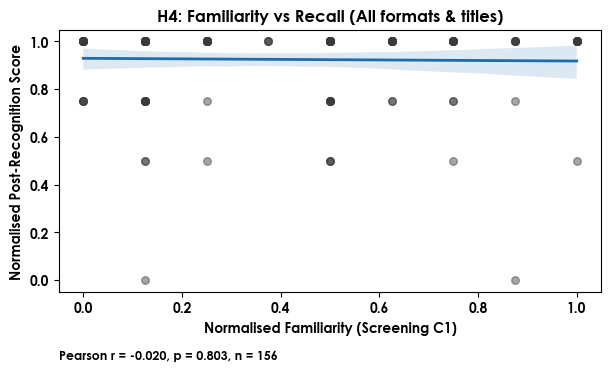

,group,pearson_r,p_value,n
0,All formats and titles,-0.020094,0.803377,156


In [406]:
overall_h4 = h4_base.copy()
if overall_h4["familiarity_norm"].nunique() < 2 or overall_h4["recall_norm"].nunique() < 2:
    raise ValueError("Familiarity or recall lacks sufficient variance for correlation analysis in Part 1.")
r_val, p_val = stats.pearsonr(overall_h4["familiarity_norm"], overall_h4["recall_norm"])
fig, ax = plt.subplots(figsize=(6.5, 4.3))
fig.subplots_adjust(bottom=0.27, right=0.96)
sns.regplot(
    data=overall_h4,
    x="familiarity_norm",
    y="recall_norm",
    scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
    line_kws={"color": "#1b6ca8", "linewidth": 2},
    ax=ax,
)
ax.set_xlabel("Normalised Familiarity (Screening C1)")
ax.set_ylabel("Normalised Post-Recognition Score")
ax.set_title("H4: Familiarity vs Recall (All formats & titles)")
annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {overall_h4.shape[0]}"
ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
plt.show()
part1_h4_summary = pd.DataFrame([
    {
        "group": "All formats and titles",
        "pearson_r": r_val,
        "p_value": p_val,
        "n": overall_h4.shape[0],
    }
])
part1_h4_summary

### Part 2: Correlations by Format
Format-specific correlations and slopes highlight whether the familiarity-recall link differs between Short and Long presentations.

(  format  pearson_r   p_value   n
 0  Short   0.080276  0.484762  78
 1   Long  -0.149643  0.190993  78,
   format     slope                          test  p_value
 0  Short  0.052731  Interaction slope difference  0.18023
 1   Long -0.070057  Interaction slope difference  0.18023,
                             sum_sq     df         F    PR(>F)
 C(form)                   0.032796    1.0  1.116555  0.292338
 familiarity_norm          0.002182    1.0  0.074293  0.785555
 familiarity_norm:C(form)  0.053233    1.0  1.812357  0.180230
 Residual                  4.464616  152.0       NaN       NaN)

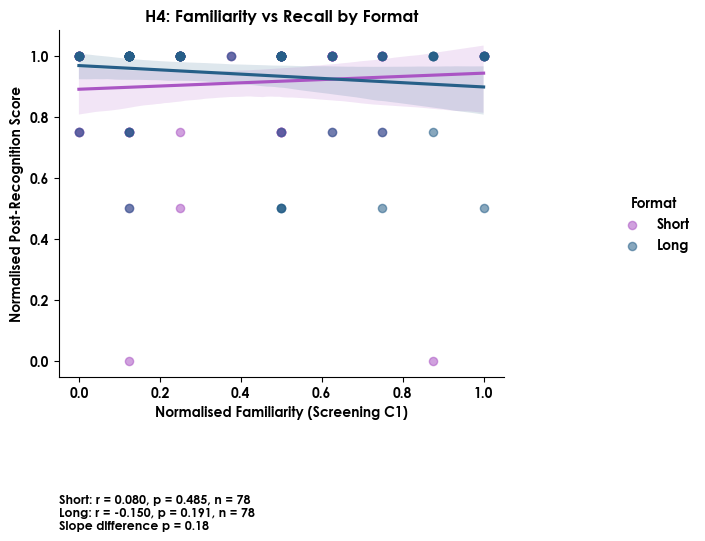

In [407]:
format_palette = {"Short": COLOR_MAP.get("Short", "#aa55c4"), "Long": COLOR_MAP.get("Long", "#265f88")}
format_summaries = []
for form, subset in overall_h4.groupby("form", observed=True):
    subset = subset.dropna(subset=["familiarity_norm", "recall_norm"])
    if subset.shape[0] < 3 or subset["familiarity_norm"].nunique() < 2 or subset["recall_norm"].nunique() < 2:
        r_form = np.nan
        p_form = np.nan
    else:
        r_form, p_form = stats.pearsonr(subset["familiarity_norm"], subset["recall_norm"])
    format_summaries.append({
        "format": form,
        "pearson_r": r_form,
        "p_value": p_form,
        "n": subset.shape[0],
    })
format_model = smf.ols("recall_norm ~ familiarity_norm * C(form)", data=overall_h4).fit()
format_anova_h4 = anova_lm(format_model, typ=2)
baseline_slope = format_model.params.get("familiarity_norm", np.nan)
interaction_term = "familiarity_norm:C(form)[T.Long]"
interaction_coef = format_model.params.get(interaction_term, np.nan)
long_slope = baseline_slope + interaction_coef if np.isfinite(baseline_slope) and np.isfinite(interaction_coef) else np.nan
format_slope_table_h4 = pd.DataFrame([
    {
        "format": "Short",
        "slope": baseline_slope,
    },
    {
        "format": "Long",
        "slope": long_slope,
    },
]).assign(test="Interaction slope difference", p_value=format_model.pvalues.get(interaction_term, np.nan))
format_plot = sns.lmplot(
    data=overall_h4,
    x="familiarity_norm",
    y="recall_norm",
    hue="form",
    palette=format_palette,
    scatter_kws={"alpha": 0.55, "s": 35},
    height=4.2,
    aspect=1.25,
    legend=False,
)
format_plot.ax.set_xlabel("Normalised Familiarity (Screening C1)")
format_plot.ax.set_ylabel("Normalised Post-Recognition Score")
format_plot.ax.set_title("H4: Familiarity vs Recall by Format")
annotation_lines = [
    "{}: r = {}, p = {}, n = {}".format(
        row["format"],
        _fmt_stat(row["pearson_r"], "{:.3f}"),
        _fmt_stat(row["p_value"], "{:.3g}"),
        row["n"],
    )
    for row in format_summaries
]
interaction_text = f"Slope difference p = {_fmt_stat(format_model.pvalues.get(interaction_term, np.nan), '{:.3g}')}"
annotation_lines.append(interaction_text)
format_plot.ax.text(0.0, -0.34, "\n".join(annotation_lines), transform=format_plot.ax.transAxes, ha="left", va="top", fontsize=9)
format_plot.add_legend(title="Format", bbox_to_anchor=(1.02, 0.5), loc="center left")
format_h4_summary = pd.DataFrame(format_summaries)
format_h4_summary, format_slope_table_h4, format_anova_h4

### Part 3: Correlations by Title
Target titles are pooled across formats to surface title-specific familiarity-recall trends and slope differences.

(               title  pearson_r   p_value   n
 0  Abbott Elementary   0.088047  0.514868  57
 1            Mad Max   0.011345  0.938999  48
 2           The Town  -0.110838  0.438750  51,
                title     slope                        test   p_value
 0  Abbott Elementary  0.027702              Baseline slope       NaN
 1            Mad Max  0.010428  Slope vs Abbott Elementary  0.885920
 2           The Town -0.060533  Slope vs Abbott Elementary  0.398518,
                                                       sum_sq     df         F  \
 C(title, Treatment(reference='Abbott Elementary'))  0.208034    2.0  3.610600   
 familiarity_norm                                    0.000127    1.0  0.004396   
 familiarity_norm:C(title, Treatment(reference='...  0.021287    2.0  0.369453   
 Residual                                            4.321325  150.0       NaN   
 
                                                       PR(>F)  
 C(title, Treatment(reference='Abbott Elementary'))  0

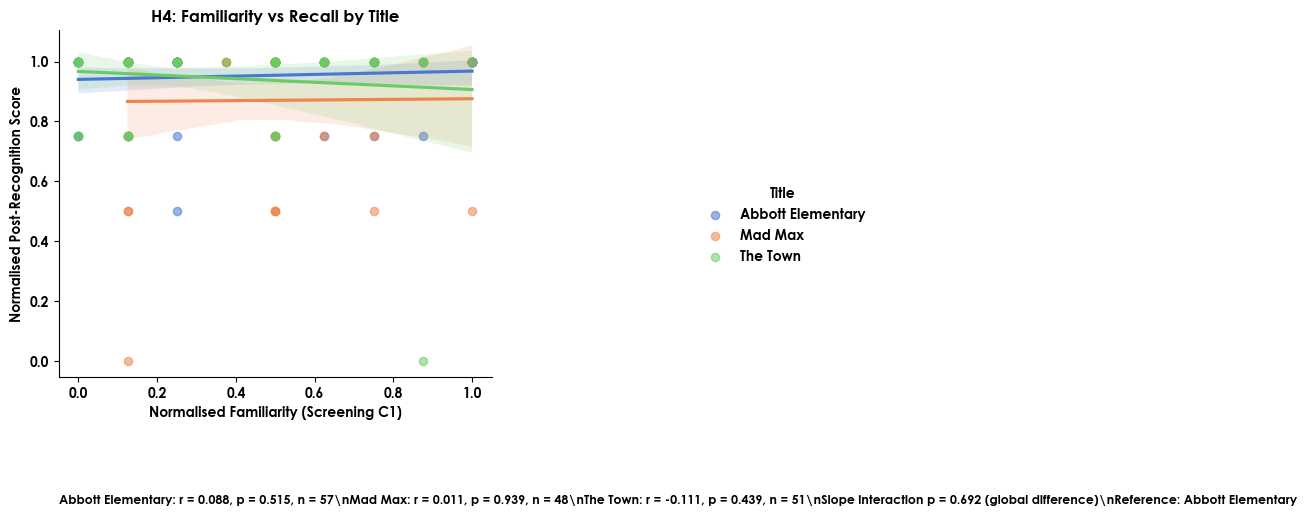

In [408]:
from statsmodels.stats.anova import anova_lm
title_subset_h4 = h4_base.loc[h4_base["title"].isin(TARGET_TITLES)].copy()
if title_subset_h4.empty:
    print("No familiarity/recall overlap for the specified target titles; skipping Part 3 plot.")
    title_h4_summary = pd.DataFrame()
    title_h4_slope_table = pd.DataFrame()
    title_anova_h4 = pd.DataFrame()
else:
    unique_titles = sorted(title_subset_h4["title"].unique())
    reference_title = unique_titles[0]
    title_palette = dict(zip(unique_titles, sns.color_palette("muted", n_colors=len(unique_titles))))
    title_summaries = []
    for title_name, subset in title_subset_h4.groupby("title", observed=True):
        subset = subset.dropna(subset=["familiarity_norm", "recall_norm"])
        if subset.shape[0] < 3 or subset["familiarity_norm"].nunique() < 2 or subset["recall_norm"].nunique() < 2:
            r_title = np.nan
            p_title = np.nan
        else:
            r_title, p_title = stats.pearsonr(subset["familiarity_norm"], subset["recall_norm"])
        title_summaries.append({
            "title": title_name,
            "pearson_r": r_title,
            "p_value": p_title,
            "n": subset.shape[0],
        })
    title_model = smf.ols(
        f"recall_norm ~ familiarity_norm * C(title, Treatment(reference='{reference_title}'))",
        data=title_subset_h4,
    ).fit()
    title_anova_h4 = anova_lm(title_model, typ=2)
    slope_entries = []
    base_slope = title_model.params.get("familiarity_norm", np.nan)
    slope_entries.append({
        "title": reference_title,
        "slope": base_slope,
        "test": "Baseline slope",
        "p_value": np.nan,
    })
    for other in unique_titles[1:]:
        param_name = f"familiarity_norm:C(title, Treatment(reference='{reference_title}'))[T.{other}]"
        interaction_coef = title_model.params.get(param_name, np.nan)
        slope_val = base_slope + interaction_coef if np.isfinite(base_slope) and np.isfinite(interaction_coef) else np.nan
        slope_entries.append({
            "title": other,
            "slope": slope_val,
            "test": f"Slope vs {reference_title}",
            "p_value": title_model.pvalues.get(param_name, np.nan),
        })
    interaction_rows = [idx for idx in title_anova_h4.index if idx.startswith("familiarity_norm:C(title, Treatment(")]
    interaction_p = title_anova_h4.loc[interaction_rows[0], "PR(>F)"] if interaction_rows else np.nan
    title_h4_slope_table = pd.DataFrame(slope_entries)
    title_plot = sns.lmplot(
        data=title_subset_h4,
        x="familiarity_norm",
        y="recall_norm",
        hue="title",
        palette=title_palette,
        scatter_kws={"alpha": 0.55, "s": 35},
        height=4.2,
        aspect=1.25,
        legend=False,
    )
    title_plot.ax.set_xlabel("Normalised Familiarity (Screening C1)")
    title_plot.ax.set_ylabel("Normalised Post-Recognition Score")
    title_plot.ax.set_title("H4: Familiarity vs Recall by Title")
    annotation_lines = [
        "{}: r = {}, p = {}, n = {}".format(
            row["title"],
            _fmt_stat(row["pearson_r"], "{:.3f}"),
            _fmt_stat(row["p_value"], "{:.3g}"),
            row["n"],
        )
        for row in title_summaries
    ]
    annotation_lines.append(
        f"Slope interaction p = {_fmt_stat(interaction_p, '{:.3g}')} (global difference)\\nReference: {reference_title}"
    )
    title_plot.ax.text(0.0, -0.34, "\\n".join(annotation_lines), transform=title_plot.ax.transAxes, ha="left", va="top", fontsize=9)
    title_plot.add_legend(title="Title", bbox_to_anchor=(1.02, 0.5), loc="center left")
    title_h4_summary = pd.DataFrame(title_summaries)
title_h4_summary, title_h4_slope_table, title_anova_h4

### Part 4: Title-Level Format Comparison
We contrast Long and Short familiarity-recall correlations within each target title, flagging significant slopes and Long-Short differences.

(               title   form  pearson_r   p_value   n
 0  Abbott Elementary   Long  -0.045432  0.821966  27
 1  Abbott Elementary  Short   0.141408  0.456048  30
 2            Mad Max   Long  -0.386105  0.062384  24
 3            Mad Max  Short   0.414147  0.044224  24
 4           The Town   Long   0.149592  0.456438  27
 5           The Town  Short  -0.209453  0.325962  24,
                title  delta_p_value
 0  Abbott Elementary       0.449674
 1            Mad Max       0.005722
 2           The Town       0.234786)

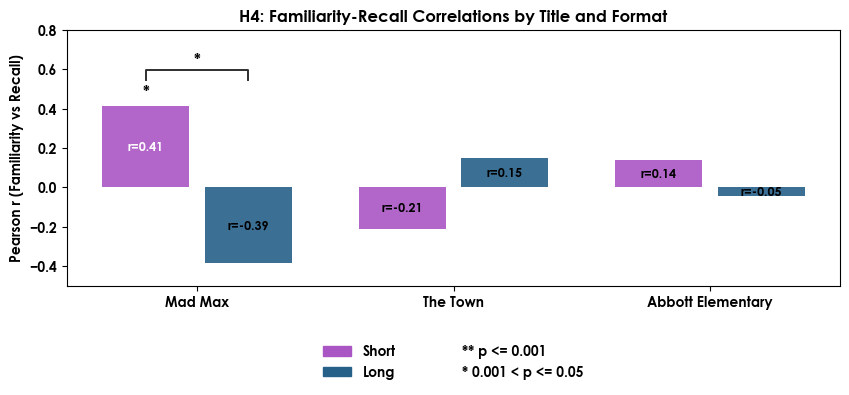

In [409]:
title_h4_correlation_records = []
title_h4_difference_records = []
for title_name, title_df in h4_base.groupby("title", observed=True):
    for form_name, form_df in title_df.groupby("form", observed=True):
        form_df = form_df.dropna(subset=["familiarity_norm", "recall_norm"])
        if form_df.shape[0] < 3 or form_df["familiarity_norm"].nunique() < 2 or form_df["recall_norm"].nunique() < 2:
            r_val = np.nan
            p_val = np.nan
        else:
            r_val, p_val = stats.pearsonr(form_df["familiarity_norm"], form_df["recall_norm"])
        title_h4_correlation_records.append({
            "title": title_name,
            "form": form_name,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": form_df.shape[0],
        })
    if title_df["form"].nunique() >= 2:
        diff_model = smf.ols("recall_norm ~ familiarity_norm * C(form)", data=title_df).fit()
        interaction_name = "familiarity_norm:C(form)[T.Long]"
        diff_p = diff_model.pvalues.get(interaction_name, np.nan)
    else:
        diff_p = np.nan
    title_h4_difference_records.append({
        "title": title_name,
        "delta_p_value": diff_p,
    })
title_h4_corr_df = pd.DataFrame(title_h4_correlation_records)
title_h4_diff_df = pd.DataFrame(title_h4_difference_records)
if title_h4_corr_df.empty:
    raise ValueError("No familiarity/recall data available for Part 4 plot.")
title_order = [t for t in TARGET_TITLES if t in title_h4_corr_df["title"].unique()] or sorted(title_h4_corr_df["title"].unique())
form_order = ["Short", "Long"]
bar_width = 0.34
x_positions = np.arange(len(title_order))
fig, ax = plt.subplots(figsize=(8.6, 4.6))
max_bar_height = 0.0
min_bar_height = 0.0
for title_idx, title_name in enumerate(title_order):
    title_subset = title_h4_corr_df.loc[title_h4_corr_df["title"] == title_name]
    local_max = 0.0
    local_min = 0.0
    for offset_idx, form_name in enumerate(form_order):
        form_row = title_subset.loc[title_subset["form"] == form_name]
        if form_row.empty:
            continue
        r_val = form_row["pearson_r"].iloc[0]
        p_val = form_row["p_value"].iloc[0]
        if not np.isfinite(r_val):
            continue
        bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
        color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
        ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
        local_max = max(local_max, r_val, 0.0)
        local_min = min(local_min, r_val, 0.0)
        annotation_label = significance_label(p_val)
        if annotation_label:
            text_offset = 0.035 if r_val >= 0 else -0.05
            va = "bottom" if r_val >= 0 else "top"
            ax.text(bar_x, r_val + text_offset, annotation_label, ha="center", va=va, fontsize=11, fontweight="bold")
        bar_text_color = "white" if r_val >= 0.25 else "black"
        text_y = r_val / 2 if r_val != 0 else 0.015
        ax.text(bar_x, text_y, f"r={r_val:.2f}", ha="center", va="center", color=bar_text_color, fontsize=9)
    max_bar_height = max(max_bar_height, local_max)
    min_bar_height = min(min_bar_height, local_min)
    diff_row = title_h4_diff_df.loc[title_h4_diff_df["title"] == title_name]
    if not diff_row.empty:
        diff_p = diff_row["delta_p_value"].iloc[0]
        diff_label = significance_label(diff_p)
        if diff_label:
            x_center = x_positions[title_idx]
            half_span = (bar_width + 0.06) / 2
            bracket_height = local_max + 0.18
            ax.plot(
                [x_center - half_span, x_center - half_span, x_center + half_span, x_center + half_span],
                [bracket_height - 0.05, bracket_height, bracket_height, bracket_height - 0.05],
                color="#2f2f2f",
                linewidth=1.4,
            )
            ax.text(x_center, bracket_height + 0.02, diff_label, ha="center", va="bottom", fontsize=11, fontweight="bold")
ax.set_xticks(x_positions)
ax.set_xticklabels(title_order)
ax.set_ylabel("Pearson r (Familiarity vs Recall)")
ax.set_title("H4: Familiarity-Recall Correlations by Title and Format")
lower_bound = min(-0.35, min_bar_height - 0.18)
upper_bound = max(0.1, max_bar_height + 0.25)
ax.set_ylim(lower_bound, upper_bound)
format_handles = [
    patches.Patch(color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")), label=form_name)
    for form_name in form_order
    if form_name in title_h4_corr_df["form"].unique()
]
sign_handles = [
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
]
legend_handles = format_handles + sign_handles
ax.legend(
    legend_handles,
    [handle.get_label() for handle in legend_handles],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=False,
)
plt.ylim(-0.5, 0.8)
plt.tight_layout(rect=(0, 0.08, 1, 1))
title_h4_corr_df.sort_values(["title", "form"]).reset_index(drop=True), title_h4_diff_df.sort_values("title").reset_index(drop=True)

In [410]:
# H4 summary tables and one-liners
if 'part1_h4_summary' in globals() and not part1_h4_summary.empty:
    display_part1 = part1_h4_summary.copy()
    if 'p_value' in display_part1.columns:
        display_part1["p_value"] = display_part1["p_value"].apply(format_p_value)
    if 'pearson_r' in display_part1.columns:
        display_part1["pearson_r"] = display_part1["pearson_r"].round(3)
    display(display_part1.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    if 'overall_h4' in globals():
        long_mean = overall_h4.loc[overall_h4["form"] == "Long", "recall_norm"].mean()
        short_mean = overall_h4.loc[overall_h4["form"] == "Short", "recall_norm"].mean()
        extra_items = []
        if 'r_val' in globals() and isinstance(r_val, Number) and np.isfinite(r_val):
            extra_items.append(f"Pearson r={r_val:.3f}")
        if 'p_val' in globals() and isinstance(p_val, Number) and np.isfinite(p_val):
            extra_items.append(format_p_value(p_val))
        long_count = overall_h4.loc[overall_h4["form"] == "Long", id_column].nunique()
        short_count = overall_h4.loc[overall_h4["form"] == "Short", id_column].nunique()
        if long_count:
            extra_items.append(f"n_long={int(long_count)}")
        if short_count:
            extra_items.append(f"n_short={int(short_count)}")
        extra_note = ", ".join(extra_items) if extra_items else None
        print_long_short_summary(
            label="H4 Part 1 (All formats)",
            long_mean=long_mean,
            short_mean=short_mean,
            extra_note=extra_note
        )
else:
    print("H4 Part 1 summary: results unavailable.")

if 'format_h4_summary' in globals() and not format_h4_summary.empty:
    formatted_format = format_h4_summary.copy()
    formatted_format["pearson_r"] = formatted_format["pearson_r"].round(3)
    formatted_format["p_value"] = formatted_format["p_value"].apply(format_p_value)
    display(formatted_format.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'format_model' in globals():
        interaction_term = "familiarity_norm:C(form)[T.Long]"
        interaction_p = format_model.pvalues.get(interaction_term, np.nan)
        if np.isfinite(interaction_p):
            interaction_note = f"Slope diff {format_p_value(interaction_p)}"
    long_mean = overall_h4.loc[overall_h4["form"] == "Long", "recall_norm"].mean() if 'overall_h4' in globals() else np.nan
    short_mean = overall_h4.loc[overall_h4["form"] == "Short", "recall_norm"].mean() if 'overall_h4' in globals() else np.nan
    sample_items = []
    long_row = formatted_format.loc[formatted_format["format"] == "Long", "n"]
    short_row = formatted_format.loc[formatted_format["format"] == "Short", "n"]
    if not long_row.empty and isinstance(long_row.iloc[0], Number) and np.isfinite(long_row.iloc[0]):
        sample_items.append(f"n_long={int(long_row.iloc[0])}")
    if not short_row.empty and isinstance(short_row.iloc[0], Number) and np.isfinite(short_row.iloc[0]):
        sample_items.append(f"n_short={int(short_row.iloc[0])}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="H4 Part 2 (By format)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H4 Part 2 summary: format correlations unavailable.")

if 'title_h4_summary' in globals() and not title_h4_summary.empty:
    formatted_title = title_h4_summary.copy()
    formatted_title["pearson_r"] = formatted_title["pearson_r"].round(3)
    formatted_title["p_value"] = formatted_title["p_value"].apply(format_p_value)
    display(formatted_title.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'title_anova_h4' in globals() and not title_anova_h4.empty:
        interaction_rows = [idx for idx in title_anova_h4.index if idx.startswith("familiarity_norm:C(")]
        if interaction_rows:
            interaction_note = f"Global slope diff {format_p_value(title_anova_h4.loc[interaction_rows[0], 'PR(>F)'])}"
    long_mean = title_subset_h4.loc[title_subset_h4["form"] == "Long", "recall_norm"].mean() if 'title_subset_h4' in globals() else np.nan
    short_mean = title_subset_h4.loc[title_subset_h4["form"] == "Short", "recall_norm"].mean() if 'title_subset_h4' in globals() else np.nan
    sample_items = []
    if 'title_subset_h4' in globals():
        long_count = title_subset_h4.loc[title_subset_h4["form"] == "Long", id_column].nunique()
        short_count = title_subset_h4.loc[title_subset_h4["form"] == "Short", id_column].nunique()
        if long_count:
            sample_items.append(f"n_long={int(long_count)}")
        if short_count:
            sample_items.append(f"n_short={int(short_count)}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="H4 Part 3 (By title)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H4 Part 3 summary: title-level correlations unavailable.")

if 'title_h4_corr_df' in globals() and not title_h4_corr_df.empty:
    display_title_corr = title_h4_corr_df.copy()
    display_title_corr["pearson_r"] = display_title_corr["pearson_r"].round(3)
    display_title_corr["p_value"] = display_title_corr["p_value"].apply(format_p_value)
    display(display_title_corr.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    long_mean = h4_base.loc[(h4_base["form"] == "Long") & (h4_base["title"].isin(TARGET_TITLES)), "recall_norm"].mean() if 'h4_base' in globals() else np.nan
    short_mean = h4_base.loc[(h4_base["form"] == "Short") & (h4_base["title"].isin(TARGET_TITLES)), "recall_norm"].mean() if 'h4_base' in globals() else np.nan
    diff_note = None
    if 'title_h4_diff_df' in globals() and not title_h4_diff_df.empty:
        best_row = title_h4_diff_df.loc[title_h4_diff_df['delta_p_value'].idxmin()]
        diff_note = f"Form slope diff {format_p_value(best_row['delta_p_value'])}"
    sample_items = []
    if 'h4_base' in globals():
        long_count = h4_base.loc[(h4_base["form"] == "Long") & (h4_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        short_count = h4_base.loc[(h4_base["form"] == "Short") & (h4_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        if long_count:
            sample_items.append(f"n_long={int(long_count)}")
        if short_count:
            sample_items.append(f"n_short={int(short_count)}")
    if diff_note:
        sample_items.append(diff_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="H4 Part 4 (Title-format comparison)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("H4 Part 4 summary: title-format correlation table unavailable.")

,group,Pearson r,p-value,n
0,All formats and titles,-0.02,p=0.803,156


H4 Part 1 (All formats): Long form (94%) showed 3% greater than short form (91%) (Pearson r=-0.045, p=0.822, n_long=78, n_short=78).


,format,Pearson r,p-value,n
0,Short,0.08,p=0.485,78
1,Long,-0.15,p=0.191,78


H4 Part 2 (By format): Long form (94%) showed 3% greater than short form (91%) (n_long=78, n_short=78, Slope diff p=0.180).


,title,Pearson r,p-value,n
0,Abbott Elementary,0.088,p=0.515,57
1,Mad Max,0.011,p=0.939,48
2,The Town,-0.111,p=0.439,51


H4 Part 3 (By title): Long form (94%) showed 3% greater than short form (91%) (n_long=78, n_short=78, Global slope diff p=0.692).


,title,form,Pearson r,p-value,n
0,Abbott Elementary,Short,0.141,p=0.456,30
1,Abbott Elementary,Long,-0.045,p=0.822,27
2,Mad Max,Short,0.414,p=0.044,24
3,Mad Max,Long,-0.386,p=0.062,24
4,The Town,Short,-0.209,p=0.326,24
5,The Town,Long,0.150,p=0.456,27


H4 Part 4 (Title-format comparison): Long form (94%) showed 3% greater than short form (91%) (n_long=78, n_short=78, Form slope diff p=0.006).


## Exploratory Analysis 1 - Enjoyment and Recall
We combine the normalised enjoyment composite with the key post-recognition scores to test whether stronger enjoyment aligns with higher recall.

In [411]:
if "recognition_long" not in globals():
    raise ValueError("Recognition outputs from H2 are unavailable; run the H2 cells before starting E1.")
enjoyment_metric_df = enjoyment_long.loc[enjoyment_long["metric"] == ENJOYMENT_METRIC].copy()
if enjoyment_metric_df.empty:
    raise ValueError("Enjoyment composite for E1 (NormalisedCorrected) is unavailable in enjoyment_long.")
enjoyment_metric_df = enjoyment_metric_df.rename(columns={"value": "enjoyment_norm"})
enjoyment_metric_df = enjoyment_metric_df.dropna(subset=["enjoyment_norm"])
enjoyment_metric_df[id_column] = enjoyment_metric_df[id_column].astype(str)
recall_metric_df = recognition_long.rename(columns={"value": "recall_norm"}).copy()
recall_metric_df = recall_metric_df.dropna(subset=["recall_norm"])
recall_metric_df[id_column] = recall_metric_df[id_column].astype(str)
e1_base = (
    enjoyment_metric_df[[id_column, "form", "title", "enjoyment_norm"]]
    .merge(
        recall_metric_df[[id_column, "form", "title", "recall_norm"]],
        on=[id_column, "form", "title"],
        how="inner",
    )
    .dropna(subset=["enjoyment_norm", "recall_norm"])
)
if e1_base.empty:
    raise ValueError("No overlapping enjoyment and recall records available for E1 analysis.")
e1_base_summary = e1_base.groupby(["form", "title"], observed=True).size().rename("records").reset_index()
e1_base_summary.head()

,form,title,records
0,Short,Abbott Elementary,30
1,Short,Mad Max,24
2,Short,The Town,24
3,Long,Abbott Elementary,27
4,Long,Mad Max,23


### Part 1: Overall Enjoyment-Recall Association
All titles and formats are pooled to quantify the overall link between normalised enjoyment and recall.

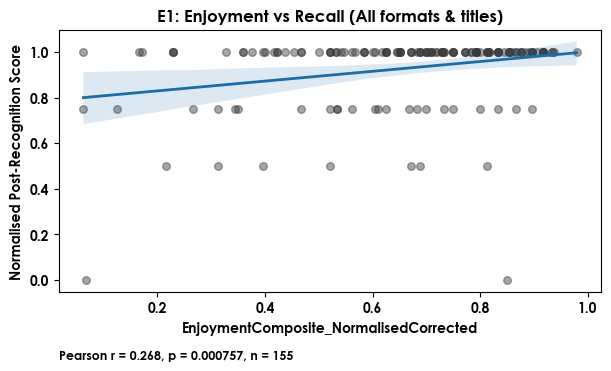

,group,pearson_r,p_value,n
0,All formats and titles,0.26774,0.000757,155


In [412]:
overall_e1 = e1_base.copy()
if overall_e1["enjoyment_norm"].nunique() < 2 or overall_e1["recall_norm"].nunique() < 2:
    raise ValueError("Enjoyment or recall lacks sufficient variance for correlation analysis in Part 1.")
r_val, p_val = stats.pearsonr(overall_e1["enjoyment_norm"], overall_e1["recall_norm"])
fig, ax = plt.subplots(figsize=(6.5, 4.3))
fig.subplots_adjust(bottom=0.27, right=0.96)
sns.regplot(
    data=overall_e1,
    x="enjoyment_norm",
    y="recall_norm",
    scatter_kws={"alpha": 0.45, "s": 30, "color": "#3a3a3a"},
    line_kws={"color": "#1b6ca8", "linewidth": 2},
    ax=ax,
)
ax.set_xlabel("EnjoymentComposite_NormalisedCorrected")
ax.set_ylabel("Normalised Post-Recognition Score")
ax.set_title("E1: Enjoyment vs Recall (All formats & titles)")
annotation = f"Pearson r = {r_val:.3f}, p = {p_val:.3g}, n = {overall_e1.shape[0]}"
ax.text(0.0, -0.22, annotation, transform=ax.transAxes, ha="left", va="top", fontsize=9)
plt.show()
part1_e1_summary = pd.DataFrame([
    {
        "group": "All formats and titles",
        "pearson_r": r_val,
        "p_value": p_val,
        "n": overall_e1.shape[0],
    }
])
part1_e1_summary

### Part 2: Correlations by Format
Format-specific correlations and slopes highlight whether the enjoyment-recall link differs between Short and Long presentations.

(  format  pearson_r   p_value   n
 0  Short   0.287401  0.010731  78
 1   Long   0.241860  0.034076  77,
   format     slope                          test   p_value
 0  Short  0.280660  Interaction slope difference  0.306528
 1   Long  0.151167  Interaction slope difference  0.306528,
                           sum_sq     df          F    PR(>F)
 C(form)                 0.027215    1.0   1.026707  0.312554
 enjoyment_norm          0.294295    1.0  11.102647  0.001084
 enjoyment_norm:C(form)  0.027904    1.0   1.052695  0.306528
 Residual                4.002518  151.0        NaN       NaN)

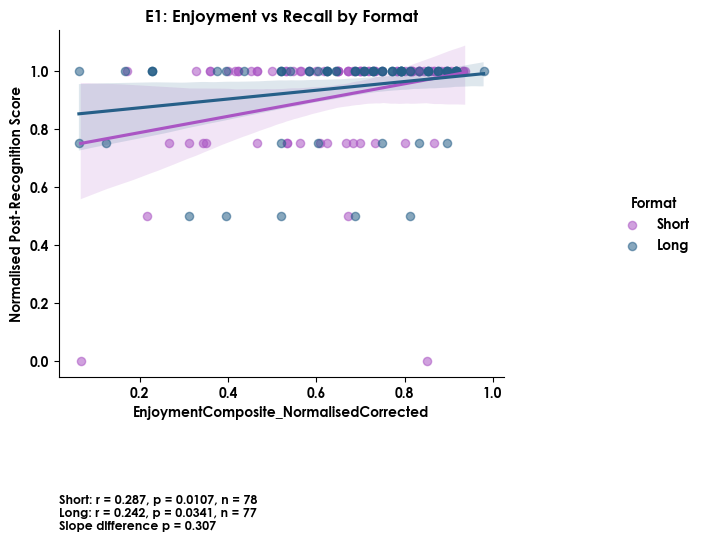

In [413]:
format_palette = {"Short": COLOR_MAP.get("Short", "#aa55c4"), "Long": COLOR_MAP.get("Long", "#265f88")}
format_summaries = []
for form, subset in overall_e1.groupby("form", observed=True):
    subset = subset.dropna(subset=["enjoyment_norm", "recall_norm"])
    if subset.shape[0] < 3 or subset["enjoyment_norm"].nunique() < 2 or subset["recall_norm"].nunique() < 2:
        r_form = np.nan
        p_form = np.nan
    else:
        r_form, p_form = stats.pearsonr(subset["enjoyment_norm"], subset["recall_norm"])
    format_summaries.append({
        "format": form,
        "pearson_r": r_form,
        "p_value": p_form,
        "n": subset.shape[0],
    })
format_model = smf.ols("recall_norm ~ enjoyment_norm * C(form)", data=overall_e1).fit()
format_anova_e1 = anova_lm(format_model, typ=2)
baseline_slope = format_model.params.get("enjoyment_norm", np.nan)
interaction_term = "enjoyment_norm:C(form)[T.Long]"
interaction_coef = format_model.params.get(interaction_term, np.nan)
long_slope = baseline_slope + interaction_coef if np.isfinite(baseline_slope) and np.isfinite(interaction_coef) else np.nan
format_slope_table_e1 = pd.DataFrame([
    {
        "format": "Short",
        "slope": baseline_slope,
    },
    {
        "format": "Long",
        "slope": long_slope,
    },
]).assign(test="Interaction slope difference", p_value=format_model.pvalues.get(interaction_term, np.nan))
format_plot = sns.lmplot(
    data=overall_e1,
    x="enjoyment_norm",
    y="recall_norm",
    hue="form",
    palette=format_palette,
    scatter_kws={"alpha": 0.55, "s": 35},
    height=4.2,
    aspect=1.25,
    legend=False,
)
format_plot.ax.set_xlabel("EnjoymentComposite_NormalisedCorrected")
format_plot.ax.set_ylabel("Normalised Post-Recognition Score")
format_plot.ax.set_title("E1: Enjoyment vs Recall by Format")
annotation_lines = [
    "{}: r = {}, p = {}, n = {}".format(
        row["format"],
        _fmt_stat(row["pearson_r"], "{:.3f}"),
        _fmt_stat(row["p_value"], "{:.3g}"),
        row["n"],
    )
    for row in format_summaries
]
interaction_text = f"Slope difference p = {_fmt_stat(format_model.pvalues.get(interaction_term, np.nan), '{:.3g}')}"
annotation_lines.append(interaction_text)
format_plot.ax.text(0.0, -0.34, "\n".join(annotation_lines), transform=format_plot.ax.transAxes, ha="left", va="top", fontsize=9)
format_plot.add_legend(title="Format", bbox_to_anchor=(1.02, 0.5), loc="center left")
format_e1_summary = pd.DataFrame(format_summaries)
format_e1_summary, format_slope_table_e1, format_anova_e1

### Part 3: Correlations by Title
Target titles are pooled across formats to surface title-specific enjoyment-recall trends and slope differences.

(               title  pearson_r   p_value   n
 0  Abbott Elementary   0.196861  0.142173  57
 1            Mad Max   0.419081  0.003368  47
 2           The Town   0.085175  0.552328  51,
                title     slope                        test   p_value
 0  Abbott Elementary  0.098298              Baseline slope       NaN
 1            Mad Max  0.409526  Slope vs Abbott Elementary  0.029779
 2           The Town  0.096833  Slope vs Abbott Elementary  0.993738,
                                                       sum_sq     df  \
 C(title, Treatment(reference='Abbott Elementary'))  0.143084    2.0   
 enjoyment_norm                                      0.288530    1.0   
 enjoyment_norm:C(title, Treatment(reference='Ab...  0.139532    2.0   
 Residual                                            3.775021  149.0   
 
                                                             F    PR(>F)  
 C(title, Treatment(reference='Abbott Elementary'))   2.823753  0.062565  
 enjoyment_norm   

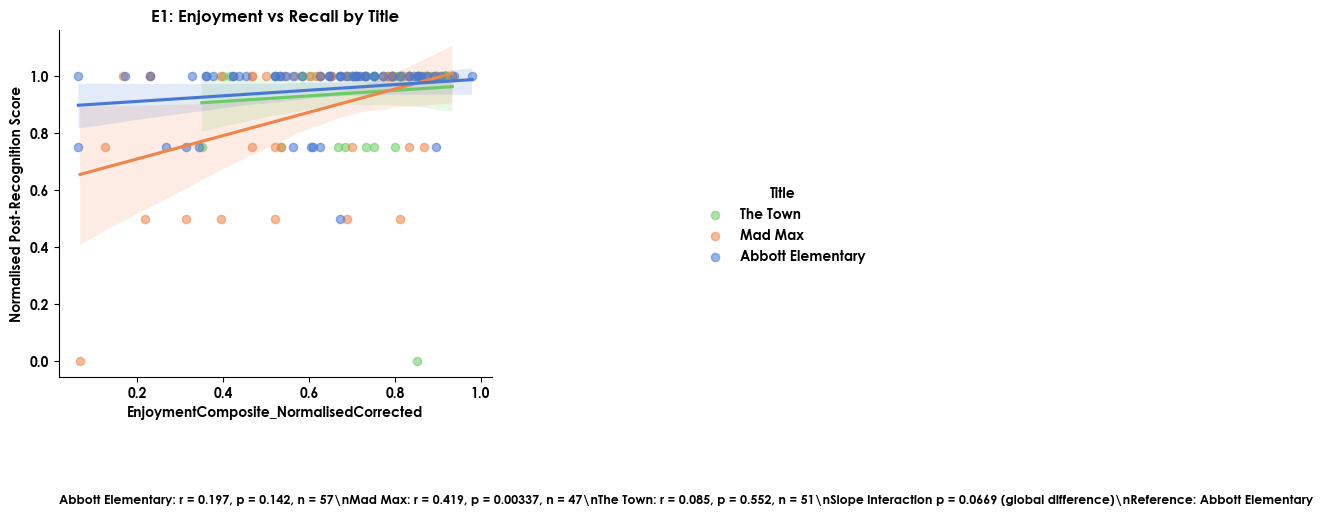

In [414]:
title_subset_e1 = e1_base.loc[e1_base["title"].isin(TARGET_TITLES)].copy()
if title_subset_e1.empty:
    print("No enjoyment/recall overlap for the specified target titles; skipping Part 3 plot.")
    title_e1_summary = pd.DataFrame()
    title_e1_slope_table = pd.DataFrame()
    title_anova_e1 = pd.DataFrame()
else:
    unique_titles = sorted(title_subset_e1["title"].unique())
    reference_title = unique_titles[0]
    title_palette = dict(zip(unique_titles, sns.color_palette("muted", n_colors=len(unique_titles))))
    title_summaries = []
    for title_name, subset in title_subset_e1.groupby("title", observed=True):
        subset = subset.dropna(subset=["enjoyment_norm", "recall_norm"])
        if subset.shape[0] < 3 or subset["enjoyment_norm"].nunique() < 2 or subset["recall_norm"].nunique() < 2:
            r_title = np.nan
            p_title = np.nan
        else:
            r_title, p_title = stats.pearsonr(subset["enjoyment_norm"], subset["recall_norm"])
        title_summaries.append({
            "title": title_name,
            "pearson_r": r_title,
            "p_value": p_title,
            "n": subset.shape[0],
        })
    title_model = smf.ols(
        f"recall_norm ~ enjoyment_norm * C(title, Treatment(reference='{reference_title}'))",
        data=title_subset_e1,
    ).fit()
    title_anova_e1 = anova_lm(title_model, typ=2)
    slope_entries = []
    base_slope = title_model.params.get("enjoyment_norm", np.nan)
    slope_entries.append({
        "title": reference_title,
        "slope": base_slope,
        "test": "Baseline slope",
        "p_value": np.nan,
    })
    for other in unique_titles[1:]:
        param_name = f"enjoyment_norm:C(title, Treatment(reference='{reference_title}'))[T.{other}]"
        interaction_coef = title_model.params.get(param_name, np.nan)
        slope_val = base_slope + interaction_coef if np.isfinite(base_slope) and np.isfinite(interaction_coef) else np.nan
        slope_entries.append({
            "title": other,
            "slope": slope_val,
            "test": f"Slope vs {reference_title}",
            "p_value": title_model.pvalues.get(param_name, np.nan),
        })
    interaction_rows = [idx for idx in title_anova_e1.index if idx.startswith("enjoyment_norm:C(title, Treatment(")]
    interaction_p = title_anova_e1.loc[interaction_rows[0], "PR(>F)"] if interaction_rows else np.nan
    title_e1_slope_table = pd.DataFrame(slope_entries)
    title_plot = sns.lmplot(
        data=title_subset_e1,
        x="enjoyment_norm",
        y="recall_norm",
        hue="title",
        palette=title_palette,
        scatter_kws={"alpha": 0.55, "s": 35},
        height=4.2,
        aspect=1.25,
        legend=False,
    )
    title_plot.ax.set_xlabel("EnjoymentComposite_NormalisedCorrected")
    title_plot.ax.set_ylabel("Normalised Post-Recognition Score")
    title_plot.ax.set_title("E1: Enjoyment vs Recall by Title")
    annotation_lines = [
        "{}: r = {}, p = {}, n = {}".format(
            row["title"],
            _fmt_stat(row["pearson_r"], "{:.3f}"),
            _fmt_stat(row["p_value"], "{:.3g}"),
            row["n"],
        )
        for row in title_summaries
    ]
    annotation_lines.append(
        f"Slope interaction p = {_fmt_stat(interaction_p, '{:.3g}')} (global difference)\\nReference: {reference_title}"
    )
    title_plot.ax.text(0.0, -0.34, "\\n".join(annotation_lines), transform=title_plot.ax.transAxes, ha="left", va="top", fontsize=9)
    title_plot.add_legend(title="Title", bbox_to_anchor=(1.02, 0.5), loc="center left")
    title_e1_summary = pd.DataFrame(title_summaries)
title_e1_summary, title_e1_slope_table, title_anova_e1

### Part 4: Title-Level Format Comparison
We contrast Long and Short enjoyment-recall correlations within each target title, flagging significant slopes and Long-Short differences.

(               title   form  pearson_r   p_value   n
 0  Abbott Elementary   Long   0.177865  0.374762  27
 1  Abbott Elementary  Short   0.193374  0.305905  30
 2            Mad Max   Long   0.158740  0.469409  23
 3            Mad Max  Short   0.703035  0.000127  24
 4           The Town   Long   0.068282  0.735052  27
 5           The Town  Short  -0.002152  0.992039  24,
                title  delta_p_value
 0  Abbott Elementary       0.654842
 1            Mad Max       0.011566
 2           The Town       0.926471)

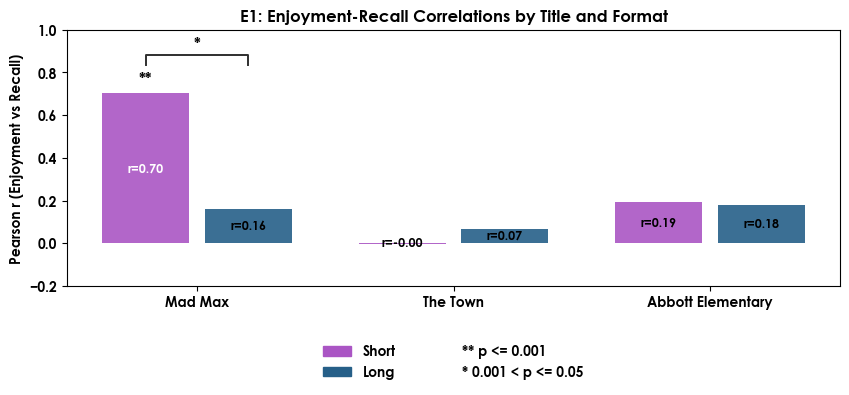

In [415]:
title_e1_correlation_records = []
title_e1_difference_records = []
for title_name, title_df in e1_base.groupby("title", observed=True):
    for form_name, form_df in title_df.groupby("form", observed=True):
        form_df = form_df.dropna(subset=["enjoyment_norm", "recall_norm"])
        if form_df.shape[0] < 3 or form_df["enjoyment_norm"].nunique() < 2 or form_df["recall_norm"].nunique() < 2:
            r_val = np.nan
            p_val = np.nan
        else:
            r_val, p_val = stats.pearsonr(form_df["enjoyment_norm"], form_df["recall_norm"])
        title_e1_correlation_records.append({
            "title": title_name,
            "form": form_name,
            "pearson_r": r_val,
            "p_value": p_val,
            "n": form_df.shape[0],
        })
    if title_df["form"].nunique() >= 2:
        diff_model = smf.ols("recall_norm ~ enjoyment_norm * C(form)", data=title_df).fit()
        interaction_name = "enjoyment_norm:C(form)[T.Long]"
        diff_p = diff_model.pvalues.get(interaction_name, np.nan)
    else:
        diff_p = np.nan
    title_e1_difference_records.append({
        "title": title_name,
        "delta_p_value": diff_p,
    })
title_e1_corr_df = pd.DataFrame(title_e1_correlation_records)
title_e1_diff_df = pd.DataFrame(title_e1_difference_records)
if title_e1_corr_df.empty:
    raise ValueError("No enjoyment/recall data available for Part 4 plot.")
title_order = [t for t in TARGET_TITLES if t in title_e1_corr_df["title"].unique()] or sorted(title_e1_corr_df["title"].unique())
form_order = ["Short", "Long"]
bar_width = 0.34
x_positions = np.arange(len(title_order))
fig, ax = plt.subplots(figsize=(8.6, 4.6))
max_bar_height = 0.0
min_bar_height = 0.0
for title_idx, title_name in enumerate(title_order):
    title_subset = title_e1_corr_df.loc[title_e1_corr_df["title"] == title_name]
    local_max = 0.0
    local_min = 0.0
    for offset_idx, form_name in enumerate(form_order):
        form_row = title_subset.loc[title_subset["form"] == form_name]
        if form_row.empty:
            continue
        r_val = form_row["pearson_r"].iloc[0]
        p_val = form_row["p_value"].iloc[0]
        if not np.isfinite(r_val):
            continue
        bar_x = x_positions[title_idx] + (offset_idx - 0.5) * (bar_width + 0.06)
        color = COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4"))
        ax.bar(bar_x, r_val, width=bar_width, color=color, alpha=0.9)
        local_max = max(local_max, r_val, 0.0)
        local_min = min(local_min, r_val, 0.0)
        annotation_label = significance_label(p_val)
        if annotation_label:
            text_offset = 0.035 if r_val >= 0 else -0.05
            va = "bottom" if r_val >= 0 else "top"
            ax.text(bar_x, r_val + text_offset, annotation_label, ha="center", va=va, fontsize=11, fontweight="bold")
        bar_text_color = "white" if r_val >= 0.25 else "black"
        text_y = r_val / 2 if r_val != 0 else 0.015
        ax.text(bar_x, text_y, f"r={r_val:.2f}", ha="center", va="center", color=bar_text_color, fontsize=9)
    max_bar_height = max(max_bar_height, local_max)
    min_bar_height = min(min_bar_height, local_min)
    diff_row = title_e1_diff_df.loc[title_e1_diff_df["title"] == title_name]
    if not diff_row.empty:
        diff_p = diff_row["delta_p_value"].iloc[0]
        diff_label = significance_label(diff_p)
        if diff_label:
            x_center = x_positions[title_idx]
            half_span = (bar_width + 0.06) / 2
            bracket_height = local_max + 0.18
            ax.plot(
                [x_center - half_span, x_center - half_span, x_center + half_span, x_center + half_span],
                [bracket_height - 0.05, bracket_height, bracket_height, bracket_height - 0.05],
                color="#2f2f2f",
                linewidth=1.4,
            )
            ax.text(x_center, bracket_height + 0.02, diff_label, ha="center", va="bottom", fontsize=11, fontweight="bold")
ax.set_xticks(x_positions)
ax.set_xticklabels(title_order)
ax.set_ylabel("Pearson r (Enjoyment vs Recall)")
ax.set_title("E1: Enjoyment-Recall Correlations by Title and Format")
lower_bound = min(-0.35, min_bar_height - 0.18)
upper_bound = max(0.1, max_bar_height + 0.25)
ax.set_ylim(lower_bound, upper_bound)
format_handles = [
    patches.Patch(color=COLOR_MAP.get(form_name, COLOR_MAP.get("Default", "#1f77b4")), label=form_name)
    for form_name in form_order
    if form_name in title_e1_corr_df["form"].unique()
]
sign_handles = [
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="** p <= 0.001"),
    plt.Line2D([], [], color="black", marker="", linestyle="None", markersize=11, label="* 0.001 < p <= 0.05"),
]
legend_handles = format_handles + sign_handles
ax.legend(
    legend_handles,
    [handle.get_label() for handle in legend_handles],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=2,
    frameon=False,
)
plt.ylim(-0.2, 1)
plt.tight_layout(rect=(0, 0.08, 1, 1))
title_e1_corr_df.sort_values(["title", "form"]).reset_index(drop=True), title_e1_diff_df.sort_values("title").reset_index(drop=True)

In [416]:
# E1 summary tables and one-liners
if 'part1_e1_summary' in globals() and not part1_e1_summary.empty:
    display_part1 = part1_e1_summary.copy()
    if 'p_value' in display_part1.columns:
        display_part1["p_value"] = display_part1["p_value"].apply(format_p_value)
    if 'pearson_r' in display_part1.columns:
        display_part1["pearson_r"] = display_part1["pearson_r"].round(3)
    display(display_part1.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    if 'overall_e1' in globals():
        long_mean = overall_e1.loc[overall_e1["form"] == "Long", "recall_norm"].mean()
        short_mean = overall_e1.loc[overall_e1["form"] == "Short", "recall_norm"].mean()
        extra_items = []
        if 'r_val' in globals() and isinstance(r_val, Number) and np.isfinite(r_val):
            extra_items.append(f"Pearson r={r_val:.3f}")
        if 'p_val' in globals() and isinstance(p_val, Number) and np.isfinite(p_val):
            extra_items.append(format_p_value(p_val))
        long_count = overall_e1.loc[overall_e1["form"] == "Long", id_column].nunique()
        short_count = overall_e1.loc[overall_e1["form"] == "Short", id_column].nunique()
        if long_count:
            extra_items.append(f"n_long={int(long_count)}")
        if short_count:
            extra_items.append(f"n_short={int(short_count)}")
        extra_note = ", ".join(extra_items) if extra_items else None
        print_long_short_summary(
            label="E1 Part 1 (All formats)",
            long_mean=long_mean,
            short_mean=short_mean,
            extra_note=extra_note
        )
else:
    print("E1 Part 1 summary: results unavailable.")

if 'format_e1_summary' in globals() and not format_e1_summary.empty:
    formatted_format = format_e1_summary.copy()
    formatted_format["pearson_r"] = formatted_format["pearson_r"].round(3)
    formatted_format["p_value"] = formatted_format["p_value"].apply(format_p_value)
    display(formatted_format.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'format_model' in globals():
        interaction_term = "enjoyment_norm:C(form)[T.Long]"
        interaction_p = format_model.pvalues.get(interaction_term, np.nan)
        if np.isfinite(interaction_p):
            interaction_note = f"Slope diff {format_p_value(interaction_p)}"
    long_mean = overall_e1.loc[overall_e1["form"] == "Long", "recall_norm"].mean() if 'overall_e1' in globals() else np.nan
    short_mean = overall_e1.loc[overall_e1["form"] == "Short", "recall_norm"].mean() if 'overall_e1' in globals() else np.nan
    sample_items = []
    long_row = formatted_format.loc[formatted_format["format"] == "Long", "n"]
    short_row = formatted_format.loc[formatted_format["format"] == "Short", "n"]
    if not long_row.empty and isinstance(long_row.iloc[0], Number) and np.isfinite(long_row.iloc[0]):
        sample_items.append(f"n_long={int(long_row.iloc[0])}")
    if not short_row.empty and isinstance(short_row.iloc[0], Number) and np.isfinite(short_row.iloc[0]):
        sample_items.append(f"n_short={int(short_row.iloc[0])}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="E1 Part 2 (By format)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("E1 Part 2 summary: format correlations unavailable.")

if 'title_e1_summary' in globals() and not title_e1_summary.empty:
    formatted_title = title_e1_summary.copy()
    formatted_title["pearson_r"] = formatted_title["pearson_r"].round(3)
    formatted_title["p_value"] = formatted_title["p_value"].apply(format_p_value)
    display(formatted_title.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    interaction_note = None
    if 'title_anova_e1' in globals() and not title_anova_e1.empty:
        interaction_rows = [idx for idx in title_anova_e1.index if idx.startswith("enjoyment_norm:C(")]
        if interaction_rows:
            interaction_note = f"Global slope diff {format_p_value(title_anova_e1.loc[interaction_rows[0], 'PR(>F)'])}"
    long_mean = title_subset_e1.loc[title_subset_e1["form"] == "Long", "recall_norm"].mean() if 'title_subset_e1' in globals() else np.nan
    short_mean = title_subset_e1.loc[title_subset_e1["form"] == "Short", "recall_norm"].mean() if 'title_subset_e1' in globals() else np.nan
    sample_items = []
    if 'title_subset_e1' in globals():
        long_count = title_subset_e1.loc[title_subset_e1["form"] == "Long", id_column].nunique()
        short_count = title_subset_e1.loc[title_subset_e1["form"] == "Short", id_column].nunique()
        if long_count:
            sample_items.append(f"n_long={int(long_count)}")
        if short_count:
            sample_items.append(f"n_short={int(short_count)}")
    if interaction_note:
        sample_items.append(interaction_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="E1 Part 3 (By title)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("E1 Part 3 summary: title-level correlations unavailable.")

if 'title_e1_corr_df' in globals() and not title_e1_corr_df.empty:
    display_title_corr = title_e1_corr_df.copy()
    display_title_corr["pearson_r"] = display_title_corr["pearson_r"].round(3)
    display_title_corr["p_value"] = display_title_corr["p_value"].apply(format_p_value)
    display(display_title_corr.rename(columns={"pearson_r": "Pearson r", "p_value": "p-value", "n": "n"}))
    long_mean = e1_base.loc[(e1_base["form"] == "Long") & (e1_base["title"].isin(TARGET_TITLES)), "recall_norm"].mean() if 'e1_base' in globals() else np.nan
    short_mean = e1_base.loc[(e1_base["form"] == "Short") & (e1_base["title"].isin(TARGET_TITLES)), "recall_norm"].mean() if 'e1_base' in globals() else np.nan
    diff_note = None
    if 'title_e1_diff_df' in globals() and not title_e1_diff_df.empty:
        best_row = title_e1_diff_df.loc[title_e1_diff_df['delta_p_value'].idxmin()]
        diff_note = f"Form slope diff {format_p_value(best_row['delta_p_value'])}"
    sample_items = []
    if 'e1_base' in globals():
        long_count = e1_base.loc[(e1_base["form"] == "Long") & (e1_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        short_count = e1_base.loc[(e1_base["form"] == "Short") & (e1_base["title"].isin(TARGET_TITLES)), id_column].nunique()
        if long_count:
            sample_items.append(f"n_long={int(long_count)}")
        if short_count:
            sample_items.append(f"n_short={int(short_count)}")
    if diff_note:
        sample_items.append(diff_note)
    extra_note = ", ".join(sample_items) if sample_items else None
    print_long_short_summary(
        label="E1 Part 4 (Title-format comparison)",
        long_mean=long_mean,
        short_mean=short_mean,
        extra_note=extra_note
    )
else:
    print("E1 Part 4 summary: title-format correlation table unavailable.")

,group,Pearson r,p-value,n
0,All formats and titles,0.268,p<0.001,155


E1 Part 1 (All formats): Long form (94%) showed 3% greater than short form (91%) (Pearson r=0.178, p=0.375, n_long=77, n_short=78).


,format,Pearson r,p-value,n
0,Short,0.287,p=0.011,78
1,Long,0.242,p=0.034,77


E1 Part 2 (By format): Long form (94%) showed 3% greater than short form (91%) (n_long=77, n_short=78, Slope diff p=0.307).


,title,Pearson r,p-value,n
0,Abbott Elementary,0.197,p=0.142,57
1,Mad Max,0.419,p=0.003,47
2,The Town,0.085,p=0.552,51


E1 Part 3 (By title): Long form (94%) showed 3% greater than short form (91%) (n_long=77, n_short=78, Global slope diff p=0.067).


,title,form,Pearson r,p-value,n
0,Abbott Elementary,Short,0.193,p=0.306,30
1,Abbott Elementary,Long,0.178,p=0.375,27
2,Mad Max,Short,0.703,p<0.001,24
3,Mad Max,Long,0.159,p=0.469,23
4,The Town,Short,-0.002,p=0.992,24
5,The Town,Long,0.068,p=0.735,27


E1 Part 4 (Title-format comparison): Long form (94%) showed 3% greater than short form (91%) (n_long=77, n_short=78, Form slope diff p=0.012).
